# Combined Tier 1: Skeleton-First Evidence Orchestration (SFEO) Research Agent

This notebook implements the **Skeleton-First Evidence Orchestration (SFEO)** architecture, combining the validated Tier 1 paradigms:

- **Iterative Refinement V2** (Patch-Based): Skeleton-driven document structure with semantic addressing
- **Agile Sprints**: Sprint-based evidence gathering with retrospectives
- **Knowledge Cache**: Cascading 3-layer cache for search optimization
- **Quality Gates**: Multi-stage quality checkpoints preventing error propagation

## Core Innovation

Traditional deep research: `Question → Research → Synthesize → Write`

SFEO inverts this: `Question → Hypothesize Structure → Research to Validate → Construct with Evidence → Refine Gaps`

## The Three Laws of SFEO

1. **Structure Precedes Content**: The document skeleton drives research, creating focused queries
2. **Quality Gates Guard Transitions**: No phase proceeds until quality criteria are met
3. **The Cache is Omnipresent**: Every search passes through the knowledge cache

## Architecture Phases

- **Phase A**: Strategic Planning (Query → Skeleton → Claims → Backlog) + Gate 1
- **Phase B**: Evidence Gathering (Sprint Loop with Cache) + Gate 2
- **Phase C**: Document Construction (Prose Patches → Bridges → Assembly) + Gate 3
- **Phase D**: Refinement & Polish (Critique → Patch → Cascade → Final)

## Technology Stack

- **LLM**: `gpt-5-mini-2025-08-07`
- **Web Search**: Tavily API
- **Embeddings**: OpenAI text-embedding-3-small
- **Tracing**: LangSmith
- **Framework**: LangGraph

## 1. Setup and Configuration

In [17]:
import os
import operator
import asyncio
import hashlib
import re
import json
from pathlib import Path
from typing import List, Dict, Tuple, Annotated, TypedDict, Literal, Optional, Any
from urllib.parse import urlparse
from datetime import datetime

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from tavily import TavilyClient

from langgraph.graph import StateGraph, START, END

import numpy as np

# Load environment variables
env_path = Path("../.env")
load_dotenv(env_path)

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

print("Environment configured successfully")

Environment configured successfully


In [18]:
# Initialize LLM, Tavily, and Embeddings
MODEL_NAME = "gpt-5-mini-2025-08-07"
llm = ChatOpenAI(model=MODEL_NAME, temperature=0, max_retries=10)
tavily_client = TavilyClient()
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# ═══════════════════════════════════════════════════════════════════════════
# PHASE A: STRATEGIC PLANNING CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════
SKELETON_CONFIG = {
    "min_sections": 4,
    "max_sections": 7,
    "target_words_per_section": 300,
    "max_skeleton_refinement_attempts": 2
}

GATE_1_CONFIG = {
    "thesis_clarity_threshold": 7.0,
    "coverage_threshold": 0.8,
    "structure_threshold": 7.0,
    "max_attempts": 2
}

# ═══════════════════════════════════════════════════════════════════════════
# PHASE B: EVIDENCE GATHERING CONFIGURATION  
# ═══════════════════════════════════════════════════════════════════════════
SPRINT_CONFIG = {
    "max_sprints": 3,
    "claims_per_sprint": 4,
    "searches_per_claim": 2,
    "min_sources_per_section": 2
}

CACHE_CONFIG = {
    "high_confidence_threshold": 0.75,
    "low_confidence_threshold": 0.40,
    "specificity_adjustment": 0.15,
    "chunk_size": 500,
    "chunk_overlap": 100,
    "top_k_retrieval": 5
}

GATE_2_CONFIG = {
    "section_coverage_threshold": 0.7,
    "min_domain_diversity": 4,
    "verification_rate_threshold": 0.6,
    "max_emergency_attempts": 1
}

# ═══════════════════════════════════════════════════════════════════════════
# PHASE C: DOCUMENT CONSTRUCTION CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════
PROSE_CONFIG = {
    "min_words_per_section": 200,
    "max_words_per_section": 500,
    "require_bridge_sentences": True
}

GATE_3_CONFIG = {
    "coherence_threshold": 6.5,
    "depth_threshold": 6.5,
    "min_citations_per_section": 1
}

# ═══════════════════════════════════════════════════════════════════════════
# PHASE D: REFINEMENT CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════
REFINEMENT_CONFIG = {
    "max_iterations": 2,
    "quality_threshold": 7.5,
    "min_improvement_threshold": 0.3,
    "max_cascades_per_iteration": 3
}

print(f"Using model: {MODEL_NAME}")
print(f"Sprint config: max {SPRINT_CONFIG['max_sprints']} sprints, {SPRINT_CONFIG['claims_per_sprint']} claims/sprint")
print(f"Cache thresholds: HIGH >= {CACHE_CONFIG['high_confidence_threshold']}, LOW < {CACHE_CONFIG['low_confidence_threshold']}")
print(f"Refinement: max {REFINEMENT_CONFIG['max_iterations']} iterations, quality target {REFINEMENT_CONFIG['quality_threshold']}")

Using model: gpt-5-mini-2025-08-07
Sprint config: max 3 sprints, 4 claims/sprint
Cache thresholds: HIGH >= 0.75, LOW < 0.4
Refinement: max 2 iterations, quality target 7.5


## 2. Data Models

Combined data models from all Tier 1 paradigms:
- **Skeleton & Claims** (from Iterative Refinement)
- **Cache Structures** (from Knowledge Cache)
- **Gate Results** (from Quality Gates)
- **Sprint Tracking** (from Agile Sprints)

In [19]:
# ═══════════════════════════════════════════════════════════════════════════
# SKELETON STRUCTURE (from Iterative Refinement)
# ═══════════════════════════════════════════════════════════════════════════

class SkeletonNode(BaseModel):
    """A node in the document skeleton hierarchy."""
    node_id: str = Field(description="Unique identifier like 'sec:intro' or 'sec:methods'")
    title: str = Field(description="Section title for the final document")
    intent: str = Field(description="1-3 sentence description of what this section should accomplish")
    target_word_count: int = Field(default=300, description="Approximate target length")
    dependencies: List[str] = Field(default_factory=list, description="Node IDs this section depends on")
    children: List[str] = Field(default_factory=list, description="Child node IDs (empty for leaf nodes)")
    claim_placeholders: List[str] = Field(default_factory=list, description="Claims this section must support")
    is_expanded: bool = Field(default=False, description="Whether prose has been generated")


class DocumentSkeleton(BaseModel):
    """The complete document skeleton structure."""
    thesis: str = Field(description="One-sentence statement of the document's central purpose")
    root_nodes: List[str] = Field(description="Top-level section node IDs in document order")
    nodes: Dict[str, SkeletonNode] = Field(default_factory=dict, description="All nodes by ID")
    style_constraints: str = Field(default="", description="Global style guidelines")


class SkeletonGenerationOutput(BaseModel):
    """Output schema for skeleton generation."""
    thesis: str = Field(description="One-sentence thesis statement")
    sections: List[SkeletonNode] = Field(description="All sections in document order")


# ═══════════════════════════════════════════════════════════════════════════
# CLAIMS & EVIDENCE (from Iterative Refinement)
# ═══════════════════════════════════════════════════════════════════════════

class Claim(BaseModel):
    """A verifiable assertion in the document."""
    claim_id: str = Field(description="Unique identifier for this claim")
    claim_text: str = Field(description="The assertion itself, stated precisely")
    source_node: str = Field(description="Skeleton node ID where this claim appears")
    verification_status: Literal["unverified", "verified", "contested", "retracted"] = Field(
        default="unverified", description="Current verification state"
    )
    supporting_evidence: List[str] = Field(default_factory=list, description="Sources supporting this claim")
    claim_dependencies: List[str] = Field(default_factory=list, description="Other claim IDs this depends on")


class ClaimExtractionOutput(BaseModel):
    """Output schema for claim extraction."""
    claims: List[Claim] = Field(description="All factual claims extracted")


class ResearchTask(BaseModel):
    """A research task in the backlog."""
    task_id: str = Field(description="Unique identifier")
    claim_id: str = Field(description="Associated claim ID")
    query: str = Field(description="Search query to execute")
    priority: int = Field(default=1, description="Priority (1=highest)")
    status: Literal["pending", "in_progress", "completed", "failed"] = Field(default="pending")
    evidence_found: List[str] = Field(default_factory=list)


# ═══════════════════════════════════════════════════════════════════════════
# PROSE ENTRIES (from Iterative Refinement)
# ═══════════════════════════════════════════════════════════════════════════

class ProseEntry(BaseModel):
    """Content stored for each expanded node."""
    node_id: str = Field(description="The skeleton node this prose belongs to")
    main_content: str = Field(description="The substantive prose for this section")
    bridge_in: str = Field(default="", description="Transitional sentences from previous section")
    bridge_out: str = Field(default="", description="Transitional sentences to next section")
    summary: str = Field(default="", description="1-2 sentence compression of content")
    revision_count: int = Field(default=0)
    citations_used: List[str] = Field(default_factory=list)


class ProseGenerationOutput(BaseModel):
    """Output schema for prose generation."""
    bridge_in: str = Field(description="Transitional sentences from previous section")
    main_content: str = Field(description="The main prose content for this section")
    bridge_out: str = Field(description="Transitional sentences to next section")
    summary: str = Field(description="1-2 sentence summary")
    citations_used: List[str] = Field(default_factory=list)


print("Skeleton and Claims models defined")

Skeleton and Claims models defined


In [20]:
# ═══════════════════════════════════════════════════════════════════════════
# CRITIQUE & NOISE MAP (from Iterative Refinement)
# ═══════════════════════════════════════════════════════════════════════════

class CritiqueIssue(BaseModel):
    """An issue identified during critique."""
    issue_id: str = Field(description="Unique identifier")
    scope: Literal["global", "section", "transition"] = Field(description="Level of the issue")
    target_nodes: List[str] = Field(description="Affected skeleton node IDs")
    issue_type: Literal["weak_claim", "missing_evidence", "logical_gap", "unclear", 
                        "coherence", "depth", "transition", "contradiction"] = Field(
        description="Category of issue"
    )
    severity: Literal["critical", "major", "minor"] = Field(description="How serious")
    affected_claims: List[str] = Field(default_factory=list, description="Claim IDs affected")
    description: str = Field(description="What the problem is")
    suggestion: str = Field(description="How to fix it")
    search_query: str = Field(default="", description="Query to find evidence if needed")


class CritiqueResult(BaseModel):
    """Complete critique output."""
    overall_quality: float = Field(description="Quality score 1-10")
    issues: List[CritiqueIssue] = Field(default_factory=list)
    strengths: str = Field(default="", description="What the document does well")
    summary: str = Field(description="Overall assessment")


# ═══════════════════════════════════════════════════════════════════════════
# CACHE STRUCTURES (from Knowledge Cache)
# ═══════════════════════════════════════════════════════════════════════════

class CachedDocument(BaseModel):
    """A cached web document."""
    url: str = Field(description="Original URL")
    normalized_url: str = Field(description="Normalized URL for lookup")
    content: str = Field(description="Full text content")
    content_hash: str = Field(description="SHA-256 hash of content")
    title: str = Field(default="", description="Page title")
    retrieval_timestamp: str = Field(description="When this was retrieved")
    source_query: str = Field(default="", description="Query that led to this content")


class CachedChunk(BaseModel):
    """A chunk of content with embedding."""
    chunk_id: str = Field(description="Unique identifier")
    text: str = Field(description="Chunk text content")
    embedding: List[float] = Field(description="Vector embedding")
    source_url: str = Field(description="Source document URL")
    position: int = Field(description="Position within source document")


class CacheDecision(BaseModel):
    """Record of a cache decision for observability."""
    query: str
    layer_reached: Literal["L1", "L2", "L3"]
    decision: Literal["HIT", "HIGH_CONF", "MEDIUM_CONF", "LOW_CONF",
                      "SUFFICIENT", "PARTIAL", "INSUFFICIENT"]
    confidence_score: float = 0.0
    action_taken: Literal["USE_CACHE", "SEARCH", "TARGETED_SEARCH"]
    reasoning: str = ""
    timestamp: str = ""


# ═══════════════════════════════════════════════════════════════════════════
# GATE RESULTS (from Quality Gates)
# ═══════════════════════════════════════════════════════════════════════════

class GateResult(BaseModel):
    """Result of a quality gate check."""
    gate_name: str = Field(description="Which gate (gate_1, gate_2, gate_3)")
    passed: bool = Field(description="Whether the gate was passed")
    scores: Dict[str, float] = Field(default_factory=dict, description="Individual criterion scores")
    reason: str = Field(description="Explanation of the gate result")
    suggestions: List[str] = Field(default_factory=list, description="Improvement suggestions")


# ═══════════════════════════════════════════════════════════════════════════
# SPRINT TRACKING (from Agile Sprints)
# ═══════════════════════════════════════════════════════════════════════════

class SprintFinding(BaseModel):
    """A finding from a research sprint."""
    claim_id: str = Field(description="The claim this finding addresses")
    finding: str = Field(description="The key finding or insight")
    sources: List[str] = Field(default_factory=list, description="Source URLs")
    cache_hit: bool = Field(default=False, description="Whether this came from cache")


print("Critique, Cache, Gate, and Sprint models defined")

Critique, Cache, Gate, and Sprint models defined


## 3. Knowledge Cache Integration

The Knowledge Cache provides a 3-layer cascading lookup:
- **Layer 1**: Deterministic deduplication (exact query/URL matching)
- **Layer 2**: Semantic similarity (vector search with confidence scoring)
- **Layer 3**: LLM judgment (gap analysis for medium-confidence hits)

In [21]:
class KnowledgeBase:
    """Session-scoped knowledge base with cascading cache capabilities."""

    def __init__(self):
        self.url_registry: Dict[str, CachedDocument] = {}
        self.query_cache: Dict[str, Dict] = {}
        self.chunks: List[CachedChunk] = []
        self.chunk_embeddings: Optional[np.ndarray] = None

        # Statistics
        self.stats = {
            "total_queries": 0,
            "l1_hits": 0,
            "l2_high": 0,
            "l2_medium": 0,
            "l2_low": 0,
            "l3_sufficient": 0,
            "l3_partial": 0,
            "l3_insufficient": 0,
            "web_searches_executed": 0,
            "web_searches_avoided": 0
        }

    # === URL Normalization ===
    def normalize_url(self, url: str) -> str:
        """Normalize URL for consistent lookup."""
        try:
            parsed = urlparse(url)
            host = parsed.netloc.lower()
            if host.startswith("www."):
                host = host[4:]
            path = parsed.path.rstrip("/")
            tracking_params = {"utm_source", "utm_medium", "utm_campaign", "ref", "fbclid"}
            query_params = sorted(parsed.query.split("&")) if parsed.query else []
            query_params = [p for p in query_params if p.split("=")[0] not in tracking_params]
            query = "&".join(query_params)
            normalized = f"https://{host}{path}"
            if query:
                normalized += f"?{query}"
            return normalized
        except:
            return url.lower()

    # === Query Normalization ===
    def normalize_query_light(self, query: str) -> str:
        """Light normalization: lowercase, collapse whitespace."""
        return " ".join(query.lower().split())

    def normalize_query_aggressive(self, query: str) -> str:
        """Aggressive normalization: remove stop words, sort terms."""
        stop_words = {"the", "a", "an", "is", "are", "of", "in", "to", "for", "and", "or", 
                      "what", "how", "why", "when", "where"}
        light = self.normalize_query_light(query)
        terms = [t for t in light.split() if t not in stop_words and len(t) > 1]
        return " ".join(sorted(terms))

    # === Content Hashing ===
    def compute_content_hash(self, content: str) -> str:
        """Compute SHA-256 hash of content."""
        return hashlib.sha256(content.encode()).hexdigest()

    # === Document Storage ===
    def add_document(self, url: str, content: str, title: str = "", source_query: str = ""):
        """Add a document to the knowledge base."""
        normalized_url = self.normalize_url(url)
        doc = CachedDocument(
            url=url,
            normalized_url=normalized_url,
            content=content,
            content_hash=self.compute_content_hash(content),
            title=title,
            retrieval_timestamp=datetime.now().isoformat(),
            source_query=source_query
        )
        self.url_registry[normalized_url] = doc
        self._chunk_and_embed(doc)
        return doc

    def _chunk_and_embed(self, doc: CachedDocument):
        """Chunk document and compute embeddings."""
        content = doc.content
        chunks_text = []
        chunk_size = CACHE_CONFIG["chunk_size"]
        chunk_overlap = CACHE_CONFIG["chunk_overlap"]

        for i in range(0, len(content), chunk_size - chunk_overlap):
            chunk_text = content[i:i + chunk_size]
            if len(chunk_text) > 50:
                chunks_text.append(chunk_text)

        if not chunks_text:
            return

        embeddings = embeddings_model.embed_documents(chunks_text)

        for i, (text, embedding) in enumerate(zip(chunks_text, embeddings)):
            chunk = CachedChunk(
                chunk_id=f"{doc.content_hash[:8]}_{i}",
                text=text,
                embedding=embedding,
                source_url=doc.url,
                position=i
            )
            self.chunks.append(chunk)

        self._update_embedding_matrix()

    def _update_embedding_matrix(self):
        """Update the numpy matrix of embeddings for fast search."""
        if self.chunks:
            self.chunk_embeddings = np.array([c.embedding for c in self.chunks])

    # === Query Cache ===
    def add_query(self, query: str, result_urls: List[str], result_summary: str):
        """Add a query to the cache."""
        entry = {
            "original_query": query,
            "light_normalized": self.normalize_query_light(query),
            "aggressive_normalized": self.normalize_query_aggressive(query),
            "timestamp": datetime.now().isoformat(),
            "result_urls": result_urls,
            "result_summary": result_summary
        }
        self.query_cache[entry["light_normalized"]] = entry
        self.query_cache[entry["aggressive_normalized"]] = entry
        return entry

    # === Lookups ===
    def lookup_query_exact(self, query: str) -> Optional[Dict]:
        """Check for exact query match."""
        light = self.normalize_query_light(query)
        return self.query_cache.get(light)

    def lookup_query_aggressive(self, query: str) -> Optional[Dict]:
        """Check for bag-of-words query match."""
        aggressive = self.normalize_query_aggressive(query)
        return self.query_cache.get(aggressive)

    # === Semantic Search ===
    def semantic_search(self, query: str, top_k: int = None) -> List[Tuple[CachedChunk, float]]:
        """Find semantically similar chunks."""
        if top_k is None:
            top_k = CACHE_CONFIG["top_k_retrieval"]
            
        if not self.chunks or self.chunk_embeddings is None:
            return []

        query_embedding = np.array(embeddings_model.embed_query(query))
        similarities = np.dot(self.chunk_embeddings, query_embedding) / (
            np.linalg.norm(self.chunk_embeddings, axis=1) * np.linalg.norm(query_embedding) + 1e-8
        )
        top_indices = np.argsort(similarities)[-top_k:][::-1]

        results = []
        for idx in top_indices:
            results.append((self.chunks[idx], float(similarities[idx])))
        return results

    def get_stats_summary(self) -> str:
        """Get human-readable stats summary."""
        total = self.stats["total_queries"]
        if total == 0:
            return "No queries processed yet."
        avoided = self.stats["web_searches_avoided"]
        hit_rate = avoided / total * 100 if total > 0 else 0
        return f"Cache: {avoided}/{total} avoided ({hit_rate:.1f}% hit rate), {len(self.chunks)} chunks indexed"


print("KnowledgeBase class defined")

KnowledgeBase class defined


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# HELPER FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════

def extract_domain(url: str) -> str:
    """Extract domain from URL."""
    try:
        parsed = urlparse(url)
        domain = parsed.netloc
        if domain.startswith("www."):
            domain = domain[4:]
        return domain
    except:
        return "unknown"


class SourcedEvidence(BaseModel):
    """Evidence with clear source attribution."""
    content: str = Field(description="The actual evidence text")
    source_url: str = Field(description="URL where this evidence was found")
    title: str = Field(default="", description="Page title")


def search_web(query: str, max_results: int = 8) -> Tuple[str, List[SourcedEvidence], List[str]]:
    """Execute web search using Tavily. Returns (summary, structured_results, urls)."""
    try:
        if len(query) > 400:
            query = query[:400]

        response = tavily_client.search(
            query=query,
            max_results=max_results,
            include_answer=True
        )

        structured_results = []
        urls = []
        summary = response.get("answer", "")

        for r in response.get("results", []):
            url = r.get('url', '')
            urls.append(url)
            content = r.get('content', '')[:600]
            title = r.get('title', 'No title')
            # Store as structured evidence with clear source association
            structured_results.append(SourcedEvidence(
                content=content,
                source_url=url,
                title=title
            ))

        return summary, structured_results, urls
    except Exception as e:
        return f"Search error: {str(e)}", [], []


def compute_confidence(top_results: List[Tuple[CachedChunk, float]], query: str) -> float:
    """Compute multi-signal confidence score for cache results."""
    if not top_results:
        return 0.0

    top_score = top_results[0][1]
    score_gap = top_results[0][1] - top_results[1][1] if len(top_results) > 1 else top_score

    query_terms = set(query.lower().split())
    top_chunk_terms = set(top_results[0][0].text.lower().split())
    term_overlap = len(query_terms & top_chunk_terms) / len(query_terms | top_chunk_terms) if query_terms | top_chunk_terms else 0

    # Weighted combination
    confidence = 0.5 * top_score + 0.25 * min(score_gap * 2, 1.0) + 0.25 * term_overlap
    return max(0.0, min(confidence, 1.0))


async def cascaded_search(query: str, kb: KnowledgeBase) -> Tuple[List[SourcedEvidence], List[str], CacheDecision]:
    """Execute the full cascading cache check and search if needed.
    
    Returns: (structured_evidence_list, urls, decision)
    """
    kb.stats["total_queries"] += 1
    timestamp = datetime.now().isoformat()

    # === Layer 1: Deterministic Deduplication ===
    exact_match = kb.lookup_query_exact(query)
    if exact_match:
        kb.stats["l1_hits"] += 1
        kb.stats["web_searches_avoided"] += 1
        # Return cached summary as single evidence item
        evidence = [SourcedEvidence(
            content=exact_match["result_summary"],
            source_url=exact_match["result_urls"][0] if exact_match["result_urls"] else "cache://query",
            title="Cached Result"
        )]
        return evidence, exact_match["result_urls"], CacheDecision(
            query=query, layer_reached="L1", decision="HIT",
            confidence_score=1.0, action_taken="USE_CACHE",
            reasoning="Exact query match in cache", timestamp=timestamp
        )

    aggressive_match = kb.lookup_query_aggressive(query)
    if aggressive_match:
        kb.stats["l1_hits"] += 1
        kb.stats["web_searches_avoided"] += 1
        evidence = [SourcedEvidence(
            content=aggressive_match["result_summary"],
            source_url=aggressive_match["result_urls"][0] if aggressive_match["result_urls"] else "cache://query",
            title="Cached Result"
        )]
        return evidence, aggressive_match["result_urls"], CacheDecision(
            query=query, layer_reached="L1", decision="HIT",
            confidence_score=0.95, action_taken="USE_CACHE",
            reasoning="Bag-of-words match in cache", timestamp=timestamp
        )

    # === Layer 2: Semantic Retrieval ===
    results = kb.semantic_search(query)
    
    if not results:
        # No cached content, go to web search
        summary, structured_results, urls = search_web(query)
        kb.stats["web_searches_executed"] += 1
        kb.stats["l2_low"] += 1
        
        # Cache results for future use
        cache_content = f"Query: {query}\n\nAnswer: {summary}\n\n" + "\n\n".join([
            f"[{e.title}] {e.content}" for e in structured_results
        ])
        synthetic_url = f"search://{kb.compute_content_hash(query)[:16]}"
        kb.add_document(synthetic_url, cache_content, title=f"Search: {query[:50]}", source_query=query)
        kb.add_query(query, urls, summary)
        
        return structured_results, urls, CacheDecision(
            query=query, layer_reached="L2", decision="LOW_CONF",
            confidence_score=0.0, action_taken="SEARCH",
            reasoning="No cached content found", timestamp=timestamp
        )

    confidence = compute_confidence(results, query)
    high_thresh = CACHE_CONFIG["high_confidence_threshold"]
    low_thresh = CACHE_CONFIG["low_confidence_threshold"]

    if confidence >= high_thresh:
        kb.stats["l2_high"] += 1
        kb.stats["web_searches_avoided"] += 1
        # Convert cache chunks to SourcedEvidence
        evidence = [
            SourcedEvidence(content=c.text, source_url=c.source_url, title="Cached")
            for c, _ in results[:3]
        ]
        urls = list(set([c.source_url for c, _ in results]))
        return evidence, urls, CacheDecision(
            query=query, layer_reached="L2", decision="HIGH_CONF",
            confidence_score=confidence, action_taken="USE_CACHE",
            reasoning=f"High semantic similarity ({confidence:.2f})", timestamp=timestamp
        )

    elif confidence < low_thresh:
        kb.stats["l2_low"] += 1
        summary, structured_results, urls = search_web(query)
        kb.stats["web_searches_executed"] += 1
        
        # Cache results
        cache_content = f"Query: {query}\n\nAnswer: {summary}\n\n" + "\n\n".join([
            f"[{e.title}] {e.content}" for e in structured_results
        ])
        synthetic_url = f"search://{kb.compute_content_hash(query)[:16]}"
        kb.add_document(synthetic_url, cache_content, title=f"Search: {query[:50]}", source_query=query)
        kb.add_query(query, urls, summary)
        
        return structured_results, urls, CacheDecision(
            query=query, layer_reached="L2", decision="LOW_CONF",
            confidence_score=confidence, action_taken="SEARCH",
            reasoning=f"Low confidence ({confidence:.2f}), executed web search", timestamp=timestamp
        )

    else:
        # === Layer 3: Medium confidence - combine cache + search ===
        kb.stats["l2_medium"] += 1
        
        # Get cached evidence
        cached_evidence = [
            SourcedEvidence(content=c.text, source_url=c.source_url, title="Cached")
            for c, _ in results[:2]
        ]
        cached_urls = [c.source_url for c, _ in results[:2]]
        
        # Execute supplementary search
        summary, new_evidence, new_urls = search_web(query, max_results=4)
        kb.stats["web_searches_executed"] += 1
        
        # Cache for future
        cache_content = f"Query: {query}\n\nAnswer: {summary}\n\n" + "\n\n".join([
            f"[{e.title}] {e.content}" for e in new_evidence
        ])
        synthetic_url = f"search://{kb.compute_content_hash(query)[:16]}"
        kb.add_document(synthetic_url, cache_content, title=f"Search: {query[:50]}", source_query=query)
        kb.add_query(query, new_urls, summary)
        
        combined_evidence = cached_evidence + new_evidence
        combined_urls = list(set(cached_urls + new_urls))
        
        kb.stats["l3_partial"] += 1
        
        return combined_evidence, combined_urls, CacheDecision(
            query=query, layer_reached="L3", decision="PARTIAL",
            confidence_score=confidence, action_taken="TARGETED_SEARCH",
            reasoning=f"Medium confidence ({confidence:.2f}), combined cache + search", timestamp=timestamp
        )


def get_leaf_nodes(skeleton: Dict[str, Any]) -> List[str]:
    """Get all leaf node IDs in document order."""
    nodes = skeleton.get("nodes", {})
    root_nodes = skeleton.get("root_nodes", [])
    valid_node_ids = set(nodes.keys())  # Only consider nodes that actually exist

    def collect_leaves(node_ids: List[str]) -> List[str]:
        leaves = []
        for nid in node_ids:
            # Skip node IDs that don't exist in the skeleton
            if nid not in valid_node_ids:
                continue
            node = nodes.get(nid, {})
            children = node.get("children", [])
            # Filter children to only include valid node IDs
            valid_children = [c for c in children if c in valid_node_ids]
            if not valid_children:
                leaves.append(nid)
            else:
                leaves.extend(collect_leaves(valid_children))
        return leaves

    result = collect_leaves(root_nodes)
    
    # Fallback: if no leaves found through tree traversal, use all nodes without children
    if not result:
        for nid, node in nodes.items():
            children = node.get("children", [])
            valid_children = [c for c in children if c in valid_node_ids]
            if not valid_children:
                result.append(nid)
    
    return result


def topological_sort_nodes(skeleton: Dict[str, Any], node_ids: List[str]) -> List[str]:
    """Sort nodes by dependency order."""
    nodes = skeleton.get("nodes", {})
    node_id_set = set(node_ids)
    remaining = set(node_ids)
    sorted_nodes = []

    while remaining:
        ready = []
        for nid in remaining:
            node = nodes.get(nid, {})
            deps = set(node.get("dependencies", []))
            internal_deps = deps & node_id_set
            if internal_deps.issubset(set(sorted_nodes)):
                ready.append(nid)

        if not ready:
            # Circular dependency - add remaining in document order
            for nid in node_ids:
                if nid in remaining:
                    sorted_nodes.append(nid)
            break

        ready_ordered = [nid for nid in node_ids if nid in ready]
        sorted_nodes.extend(ready_ordered)
        remaining -= set(ready_ordered)

    return sorted_nodes


def get_adjacent_nodes(skeleton: Dict[str, Any], node_id: str) -> Tuple[Optional[str], Optional[str]]:
    """Get the previous and next node IDs in document order."""
    leaves = get_leaf_nodes(skeleton)
    try:
        idx = leaves.index(node_id)
        prev_node = leaves[idx - 1] if idx > 0 else None
        next_node = leaves[idx + 1] if idx < len(leaves) - 1 else None
        return prev_node, next_node
    except ValueError:
        return None, None


print("Helper functions defined")

Helper functions defined


## 4. Unified State Schema

The SFEO state combines all phase requirements into a single TypedDict.

In [23]:
class SFEOState(TypedDict):
    """Complete state for the SFEO architecture."""
    
    # ═══════════════════════════════════════════════════════════════════════
    # INPUT
    # ═══════════════════════════════════════════════════════════════════════
    question: str
    
    # ═══════════════════════════════════════════════════════════════════════
    # PHASE A: STRATEGIC PLANNING
    # ═══════════════════════════════════════════════════════════════════════
    preliminary_findings: List[str]  # Initial research results
    skeleton: Dict[str, Any]  # DocumentSkeleton as dict
    claims_registry: Dict[str, Dict[str, Any]]  # claim_id → Claim as dict
    research_backlog: List[Dict[str, Any]]  # List of ResearchTask as dicts
    
    # Gate 1 tracking
    gate_1_attempts: int
    gate_1_passed: bool
    
    # ═══════════════════════════════════════════════════════════════════════
    # PHASE B: EVIDENCE GATHERING
    # ═══════════════════════════════════════════════════════════════════════
    current_sprint: int
    max_sprints: int
    sprint_findings: Annotated[List[str], operator.add]  # Accumulates
    
    # Cache decisions for observability
    cache_decisions: Annotated[List[Dict], operator.add]
    
    # Evidence tracking (accumulated)
    source_urls: Annotated[List[str], operator.add]
    evidence_map: Dict[str, List[str]]  # claim_id → [evidence snippets]
    
    # Retrospective notes
    retrospective_notes: Annotated[List[str], operator.add]
    should_stop_sprinting: bool
    
    # Gate 2 tracking
    gate_2_attempts: int
    gate_2_passed: bool
    
    # ═══════════════════════════════════════════════════════════════════════
    # PHASE C: DOCUMENT CONSTRUCTION
    # ═══════════════════════════════════════════════════════════════════════
    prose_store: Dict[str, Dict[str, Any]]  # node_id → ProseEntry as dict
    global_references: Dict[int, Dict[str, str]]  # ref_num → {url, title}
    assembled_draft: str
    
    # Gate 3 tracking
    gate_3_passed: bool
    gate_3_scores: Dict[str, float]
    
    # ═══════════════════════════════════════════════════════════════════════
    # PHASE D: REFINEMENT
    # ═══════════════════════════════════════════════════════════════════════
    iteration_count: int
    noise_map: List[Dict[str, Any]]  # List of CritiqueIssue as dicts
    nodes_to_patch: List[str]
    targeted_evidence: Dict[str, List[Dict]]  # node_id → List[evidence dicts]
    quality_scores: Annotated[List[float], operator.add]
    
    # ═══════════════════════════════════════════════════════════════════════
    # OUTPUT
    # ═══════════════════════════════════════════════════════════════════════
    final_report: str


# Initialize global knowledge base (will be reset per session)
knowledge_base: KnowledgeBase = None

print("SFEOState schema defined")

SFEOState schema defined


## 5. Prompts Library

Consolidated prompts for all SFEO phases.

In [24]:
# ═══════════════════════════════════════════════════════════════════════════
# PHASE A PROMPTS: STRATEGIC PLANNING
# ═══════════════════════════════════════════════════════════════════════════

SKELETON_GENERATION_PROMPT = """You are a research document architect designing a comprehensive report structure.

RESEARCH QUESTION: {question}

PRELIMINARY RESEARCH FINDINGS:
{preliminary_findings}

Create a hierarchical document skeleton with:
1. A clear thesis statement (one sentence capturing the central argument)
2. 5-7 main sections appropriate for a comprehensive research report
3. Each section should have:
   - node_id: Unique identifier (e.g., "sec:intro", "sec:background", "sec:analysis")
   - title: Descriptive section title
   - intent: 1-3 sentences describing what this section should accomplish
   - target_word_count: 250-400 words per section
   - dependencies: List of node_ids this section builds upon (empty for first sections)
   - claim_placeholders: 2-3 specific claims this section must support (make these searchable)

REQUIRED SECTIONS (adapt titles to topic):
1. Introduction - Present the topic, context, and thesis
2. Background/Context - Provide necessary foundation knowledge  
3. Main Body (2-4 sections) - Cover key aspects in depth
4. Analysis/Discussion - Synthesize findings and discuss implications
5. Conclusion - Summarize key points and future directions

IMPORTANT:
- Node IDs must be unique and follow format: sec:topic
- Dependencies must reference existing node_ids (no forward references)
- claim_placeholders should be specific and searchable, not vague
"""

CLAIM_EXTRACTION_PROMPT = """Extract all verifiable claims from this skeleton's claim_placeholders.

SKELETON:
{skeleton_json}

For each claim placeholder across all sections, create a claim entry with:
- claim_id: Unique ID using format claim_{{node_id}}_{{number}}
- claim_text: The specific assertion to verify
- source_node: The section node_id
- verification_status: "unverified"

Focus on claims that are:
- Specific and factual (not opinions)
- Searchable (can find evidence online)
- Central to answering the research question
"""

GATE_1_EVALUATION_PROMPT = """Evaluate this document skeleton for quality.

RESEARCH QUESTION: {question}

SKELETON:
Thesis: {thesis}
Sections: {sections_summary}

Evaluate on these criteria (score 1-10 each):

1. THESIS_CLARITY: Is the thesis clear, specific, and arguable?
2. COVERAGE: Does the skeleton address ALL parts of the research question?
3. STRUCTURE: Is the hierarchy logical? Do dependencies make sense?
4. CLAIM_SPECIFICITY: Are claim_placeholders specific enough to research?

Format response as:
THESIS_CLARITY: [score]
COVERAGE: [score]  
STRUCTURE: [score]
CLAIM_SPECIFICITY: [score]
OVERALL: [average score]
ISSUES: [List any problems, or "None"]
"""

# ═══════════════════════════════════════════════════════════════════════════
# PHASE B PROMPTS: EVIDENCE GATHERING
# ═══════════════════════════════════════════════════════════════════════════

SPRINT_PLANNING_PROMPT = """Select claims to verify in this research sprint.

REMAINING UNVERIFIED CLAIMS:
{unverified_claims}

ALREADY VERIFIED CLAIMS:
{verified_claims}

Select up to {claims_per_sprint} claims to verify in this sprint.
Prioritize claims that are:
1. Central to the thesis
2. Quantitative or easily verifiable
3. Related to each other (for cache efficiency)

For each selected claim, provide a search query.

Format as JSON array:
[
  {{"claim_id": "...", "query": "specific search query"}}
]
"""

SPRINT_RETROSPECTIVE_PROMPT = """Conduct a sprint retrospective for research progress.

ORIGINAL QUESTION: {question}

SPRINT {sprint_num} of {max_sprints} COMPLETED.

CLAIMS VERIFIED THIS SPRINT:
{verified_this_sprint}

REMAINING UNVERIFIED:
{remaining_unverified}

CACHE PERFORMANCE:
- Queries: {total_queries}
- Cache hits: {cache_hits} ({hit_rate:.1f}%)

Analyze and provide:

## LEARNINGS
What key insights did we gain?

## GAPS  
What is still unclear or needs investigation?

## CONTINUE
Should we continue with another sprint? YES or NO with justification.
Consider: If most claims are verified or cache hit rate is high, we may stop.

## PRIORITY_CLAIMS
If continuing, list the 2-4 most important remaining claims to verify:
"""

# ═══════════════════════════════════════════════════════════════════════════
# PHASE C PROMPTS: DOCUMENT CONSTRUCTION
# ═══════════════════════════════════════════════════════════════════════════

PROSE_GENERATION_PROMPT = """Generate prose content for a specific section of a research report.

SECTION CONTEXT:
- Node ID: {node_id}
- Title: {title}
- Intent: {intent}
- Target Word Count: {target_words}

EVIDENCE SOURCES (numbered for citation):
{numbered_evidence}

CONTEXT FROM ADJACENT SECTIONS:
- Previous Section Summary: {prev_summary}
- Next Section Preview: {next_preview}

WRITING REQUIREMENTS:
1. Write substantive, specific prose that synthesizes the evidence above
2. Use NUMBERED citations like [1], [2], [3] - NOT inline URLs
3. Only cite when making a specific factual claim from the evidence
4. Do NOT cite every sentence - aim for 2-4 citations per paragraph maximum
5. Extract specific numbers, percentages, and concrete details from the evidence
6. Create smooth transitions (bridge_in from previous, bridge_out to next)
7. Write in a professional, flowing academic style

CITATION STYLE:
- GOOD: "According to recent surveys, 78% of enterprises plan to increase LLM investment [1]."
- BAD: "Enterprises are investing in LLMs [Source: https://example.com]."
- BAD: "This is important [1]. This is also relevant [2]. Another point [3]." (over-citation)

Output as JSON:
{{
  "bridge_in": "1-2 transitional sentences from previous section",
  "main_content": "The main prose (~{target_words} words) with numbered citations like [1], [2]",
  "bridge_out": "1-2 transitional sentences to next section",
  "summary": "What this section establishes",
  "citations_used": [1, 2, 3]
}}
"""

GATE_3_EVALUATION_PROMPT = """Evaluate this assembled draft for quality.

ORIGINAL QUESTION: {question}

DRAFT:
{draft}

Evaluate on these criteria (score 1-10 each):

1. COHERENCE: Does the document flow logically from section to section?
2. DEPTH: Does the analysis go beyond surface-level information?
3. EVIDENCE: Are claims well-supported with citations?
4. COMPLETENESS: Does it fully answer the research question?

Format response as:
COHERENCE: [score]
DEPTH: [score]
EVIDENCE: [score]
COMPLETENESS: [score]
OVERALL: [average]
ISSUES: [List problems needing attention, or "None"]
"""

# ═══════════════════════════════════════════════════════════════════════════
# PHASE D PROMPTS: REFINEMENT
# ═══════════════════════════════════════════════════════════════════════════

STRUCTURED_CRITIQUE_PROMPT = """Conduct a rigorous review of this research report.

ORIGINAL QUESTION: {question}

DOCUMENT SKELETON:
{skeleton_summary}

CLAIMS REGISTRY:
{claims_summary}

ASSEMBLED DRAFT:
{draft}

Analyze at THREE levels and produce a Noise Map:

1. GLOBAL ISSUES: Thesis support, overall coherence, terminology consistency
2. SECTION ISSUES: Weak claims, missing evidence, logical gaps, depth
3. TRANSITION ISSUES: Abrupt shifts, weak bridges, broken references

For EACH issue, provide:
- issue_id: Unique ID (e.g., "I001")
- scope: "global", "section", or "transition"
- target_nodes: List of affected node IDs
- issue_type: weak_claim, missing_evidence, logical_gap, unclear, coherence, depth, transition
- severity: "critical", "major", or "minor"
- description: What the problem is
- suggestion: How to fix it
- search_query: If evidence-related, a query to find supporting sources

SCORING (1-10):
- 9-10: Publication ready
- 7-8: Good, minor issues only
- 5-6: Acceptable, needs improvement
- 3-4: Significant problems
- 1-2: Major rework needed

Output as JSON with overall_quality score and issues array.
"""

PATCH_APPLICATION_PROMPT = """Revise this section based on critique feedback and new evidence.

SECTION TO REVISE:
- Node ID: {node_id}
- Title: {title}
- Intent: {intent}

CURRENT CONTENT:
{current_content}

ISSUES TO ADDRESS:
{issues}

NEW EVIDENCE (numbered for citation):
{new_evidence}

ADJACENT CONTEXT:
- Previous section ends: {prev_bridge_out}
- Next section starts: {next_bridge_in}

REVISION REQUIREMENTS:
1. Address ALL identified issues in the revision
2. Use NUMBERED citations like [1], [2] when referencing new evidence
3. Do NOT use inline URLs - only numbered references
4. Maintain smooth transitions with adjacent sections
5. Keep approximately the same length
6. Extract specific facts and details from the evidence

Output revised section as JSON with bridge_in, main_content, bridge_out, summary.
"""

print("Prompts library defined")

Prompts library defined


## 6. Phase A: Strategic Planning

Phase A establishes the document "contract":
1. Preliminary research to inform skeleton
2. Generate document skeleton with semantic nodes
3. Extract verifiable claims from skeleton
4. Create research backlog from claims
5. Gate 1: Validate skeleton quality

In [25]:
async def preliminary_research(state: SFEOState) -> dict:
    """Conduct lightweight initial research to inform skeleton generation."""
    question = state["question"]
    
    print(f"\n{'='*60}")
    print("Phase A.1: Preliminary Research")
    print(f"{'='*60}")
    
    # Generate 3-4 broad search queries
    query_prompt = f"""Generate 4 search queries to understand the scope of this research question:
    
Question: {question}

Return 4 queries, one per line, covering different aspects."""
    
    response = await llm.ainvoke([HumanMessage(content=query_prompt)])
    queries = [q.strip() for q in response.content.split("\n") if q.strip()][:4]
    
    all_results = []
    all_urls = []
    
    for query in queries:
        print(f"  Searching: {query[:50]}...")
        summary, results, urls = search_web(query, max_results=5)
        # Convert SourcedEvidence objects to formatted strings for state storage
        for r in results:
            all_results.append(f"[{r.title}] {r.content}")
        all_urls.extend(urls)
    
    print(f"  Collected {len(all_results)} preliminary results")
    
    return {
        "preliminary_findings": all_results,
        "source_urls": all_urls,
        "gate_1_attempts": 0,
        "gate_1_passed": False
    }


async def generate_skeleton(state: SFEOState) -> dict:
    """Generate the document skeleton structure."""
    question = state["question"]
    preliminary_findings = state.get("preliminary_findings", [])
    
    print(f"\n{'='*60}")
    print("Phase A.2: Skeleton Generation")
    print(f"{'='*60}")
    
    findings_summary = "\n".join(preliminary_findings[:15])
    
    prompt = SKELETON_GENERATION_PROMPT.format(
        question=question,
        preliminary_findings=findings_summary
    )
    
    structured_llm = llm.with_structured_output(SkeletonGenerationOutput)
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    # Build skeleton dictionary
    skeleton = {
        "thesis": result.thesis,
        "root_nodes": [],
        "nodes": {},
        "style_constraints": "Academic tone, comprehensive analysis, evidence-based claims"
    }
    
    child_ids = set()
    for section in result.sections:
        child_ids.update(section.children)
    
    for section in result.sections:
        skeleton["nodes"][section.node_id] = section.model_dump()
        if section.node_id not in child_ids:
            skeleton["root_nodes"].append(section.node_id)
    
    if not skeleton["root_nodes"]:
        for nid, node in skeleton["nodes"].items():
            if not node.get("dependencies", []):
                skeleton["root_nodes"].append(nid)
    
    if not skeleton["root_nodes"]:
        skeleton["root_nodes"] = list(skeleton["nodes"].keys())
    
    print(f"  Thesis: {result.thesis[:80]}...")
    print(f"  Generated {len(skeleton['nodes'])} skeleton nodes:")
    for nid, node in skeleton["nodes"].items():
        deps = node.get('dependencies', [])
        dep_str = f" (depends: {', '.join(deps)})" if deps else ""
        print(f"    - {nid}: {node['title']}{dep_str}")
    
    return {"skeleton": skeleton}


async def identify_claims(state: SFEOState) -> dict:
    """Extract verifiable claims from the skeleton's claim_placeholders."""
    skeleton = state["skeleton"]
    
    print(f"\n{'='*60}")
    print("Phase A.3: Claim Identification")
    print(f"{'='*60}")
    
    claims_registry = {}
    claim_counter = 1
    
    for node_id, node in skeleton["nodes"].items():
        placeholders = node.get("claim_placeholders", [])
        for placeholder in placeholders:
            claim_id = f"claim_{node_id}_{claim_counter}"
            claims_registry[claim_id] = {
                "claim_id": claim_id,
                "claim_text": placeholder,
                "source_node": node_id,
                "verification_status": "unverified",
                "supporting_evidence": [],
                "claim_dependencies": []
            }
            claim_counter += 1
    
    print(f"  Extracted {len(claims_registry)} claims from skeleton:")
    for cid, claim in list(claims_registry.items())[:5]:
        print(f"    - {cid}: {claim['claim_text'][:50]}...")
    if len(claims_registry) > 5:
        print(f"    ... and {len(claims_registry) - 5} more")
    
    return {"claims_registry": claims_registry}


async def create_research_backlog(state: SFEOState) -> dict:
    """Create prioritized research backlog from claims."""
    claims_registry = state["claims_registry"]
    
    print(f"\n{'='*60}")
    print("Phase A.4: Research Backlog Creation")
    print(f"{'='*60}")
    
    backlog = []
    priority = 1
    
    for claim_id, claim in claims_registry.items():
        # Generate search query from claim text
        query = claim["claim_text"]
        if len(query) > 100:
            query = query[:100]
        
        task = {
            "task_id": f"task_{claim_id}",
            "claim_id": claim_id,
            "query": query,
            "priority": priority,
            "status": "pending",
            "evidence_found": []
        }
        backlog.append(task)
        priority += 1
    
    print(f"  Created backlog with {len(backlog)} research tasks")
    
    return {
        "research_backlog": backlog,
        "evidence_map": {},
        "current_sprint": 1,
        "max_sprints": SPRINT_CONFIG["max_sprints"]
    }


async def skeleton_quality_gate(state: SFEOState) -> dict:
    """Gate 1: Evaluate skeleton quality."""
    skeleton = state["skeleton"]
    question = state["question"]
    attempts = state.get("gate_1_attempts", 0) + 1
    
    print(f"\n--- Gate 1: Skeleton Quality (Attempt {attempts}/{GATE_1_CONFIG['max_attempts'] + 1}) ---")
    
    # Build sections summary
    sections_summary = "\n".join([
        f"- {nid}: {node['title']} - {node.get('intent', '')[:60]}..."
        for nid, node in skeleton["nodes"].items()
    ])
    
    prompt = GATE_1_EVALUATION_PROMPT.format(
        question=question,
        thesis=skeleton.get("thesis", ""),
        sections_summary=sections_summary
    )
    
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    content = response.content
    
    # Parse scores
    scores = {}
    for metric in ["THESIS_CLARITY", "COVERAGE", "STRUCTURE", "CLAIM_SPECIFICITY", "OVERALL"]:
        match = re.search(rf'{metric}:\s*(\d+(?:\.\d+)?)', content)
        if match:
            scores[metric.lower()] = float(match.group(1))
    
    overall = scores.get("overall", 7.0)
    
    # Check if passes
    passed = (
        scores.get("thesis_clarity", 0) >= GATE_1_CONFIG["thesis_clarity_threshold"] and
        scores.get("structure", 0) >= GATE_1_CONFIG["structure_threshold"] and
        overall >= 6.5
    )
    
    print(f"  Thesis Clarity: {scores.get('thesis_clarity', 'N/A')}/10")
    print(f"  Coverage: {scores.get('coverage', 'N/A')}/10")
    print(f"  Structure: {scores.get('structure', 'N/A')}/10")
    print(f"  Overall: {overall}/10")
    print(f"  {'PASSED' if passed else 'FAILED'} Gate 1")
    
    return {
        "gate_1_attempts": attempts,
        "gate_1_passed": passed
    }


def route_after_gate_1(state: SFEOState) -> Literal["initialize_cache", "refine_skeleton", "initialize_cache_anyway"]:
    """Route based on Gate 1 result."""
    passed = state.get("gate_1_passed", False)
    attempts = state.get("gate_1_attempts", 0)
    
    if passed:
        return "initialize_cache"
    elif attempts <= GATE_1_CONFIG["max_attempts"]:
        return "refine_skeleton"
    else:
        print("  Max Gate 1 attempts reached. Proceeding anyway.")
        return "initialize_cache_anyway"


async def refine_skeleton(state: SFEOState) -> dict:
    """Refine skeleton after Gate 1 failure."""
    skeleton = state["skeleton"]
    question = state["question"]
    
    print(f"\n  Refining skeleton...")
    
    # Simple refinement: regenerate with emphasis on issues
    prompt = f"""The previous skeleton for this question had quality issues. Generate an improved version.

Question: {question}

Previous thesis: {skeleton.get('thesis', '')}

Improve:
1. Make the thesis more specific and arguable
2. Ensure all question aspects are covered
3. Make claim_placeholders more specific and searchable
"""
    
    structured_llm = llm.with_structured_output(SkeletonGenerationOutput)
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    # Rebuild skeleton
    new_skeleton = {
        "thesis": result.thesis,
        "root_nodes": [],
        "nodes": {},
        "style_constraints": skeleton.get("style_constraints", "")
    }
    
    for section in result.sections:
        new_skeleton["nodes"][section.node_id] = section.model_dump()
        new_skeleton["root_nodes"].append(section.node_id)
    
    print(f"  Refined skeleton with {len(new_skeleton['nodes'])} sections")
    
    return {"skeleton": new_skeleton}


print("Phase A node functions defined")

Phase A node functions defined


## 7. Phase B: Evidence Gathering

Phase B executes sprint-based evidence collection with cache integration:
1. Initialize session knowledge base
2. Sprint loop: plan → cache-aware search → update claims → retrospective
3. Gate 2: Validate evidence sufficiency

In [26]:
async def initialize_cache(state: SFEOState) -> dict:
    """Initialize the session knowledge base."""
    global knowledge_base
    
    print(f"\n{'='*60}")
    print("Phase B.0: Initialize Knowledge Cache")
    print(f"{'='*60}")
    
    knowledge_base = KnowledgeBase()
    
    # Pre-populate cache with preliminary findings
    preliminary = state.get("preliminary_findings", [])
    if preliminary:
        content = "\n\n".join(preliminary)
        knowledge_base.add_document(
            "preliminary://research",
            content,
            title="Preliminary Research",
            source_query=state["question"]
        )
        print(f"  Pre-populated cache with {len(preliminary)} preliminary findings")
    
    print(f"  Knowledge base initialized")
    
    return {
        "should_stop_sprinting": False,
        "gate_2_attempts": 0,
        "gate_2_passed": False
    }


async def sprint_execute(state: SFEOState) -> dict:
    """Execute a research sprint with cache-aware searching."""
    global knowledge_base
    
    current_sprint = state.get("current_sprint", 1)
    max_sprints = state.get("max_sprints", SPRINT_CONFIG["max_sprints"])
    claims_registry = state.get("claims_registry", {})
    evidence_map = state.get("evidence_map", {})
    
    print(f"\n{'='*60}")
    print(f"Phase B.1: Sprint {current_sprint}/{max_sprints}")
    print(f"{'='*60}")
    
    # Get unverified claims for this sprint
    unverified = [
        (cid, claim) for cid, claim in claims_registry.items()
        if claim.get("verification_status") == "unverified"
    ]
    
    claims_to_verify = unverified[:SPRINT_CONFIG["claims_per_sprint"]]
    
    if not claims_to_verify:
        print("  No unverified claims remaining")
        return {
            "should_stop_sprinting": True,
            "sprint_findings": ["No unverified claims remaining in sprint"]
        }
    
    print(f"  Verifying {len(claims_to_verify)} claims this sprint")
    
    findings = []
    all_urls = []
    cache_decisions = []
    verified_count = 0
    cache_hits = 0
    
    for claim_id, claim in claims_to_verify:
        query = claim["claim_text"][:150]  # Truncate for search
        
        print(f"\n  [{claim_id}] {query[:50]}...")
        
        # Execute cache-aware search - returns List[SourcedEvidence]
        evidence_list, urls, decision = await cascaded_search(query, knowledge_base)
        
        cache_decisions.append(decision.model_dump())
        all_urls.extend(urls)
        
        if decision.action_taken == "USE_CACHE":
            cache_hits += 1
            print(f"    CACHE HIT ({decision.layer_reached})")
        else:
            print(f"    WEB SEARCH ({decision.layer_reached})")
        
        # Update claim verification with structured evidence
        claims_registry[claim_id]["verification_status"] = "verified"
        # Store evidence as list of dicts with content AND source URL
        claims_registry[claim_id]["supporting_evidence"] = [
            {"content": e.content[:500], "source_url": e.source_url, "title": e.title}
            for e in evidence_list[:3]
        ]
        verified_count += 1
        
        # Update evidence map with STRUCTURED evidence (content + URL)
        if claim_id not in evidence_map:
            evidence_map[claim_id] = []
        evidence_map[claim_id] = [
            {"content": e.content, "source_url": e.source_url, "title": e.title}
            for e in evidence_list[:3]  # Keep top 3 sources per claim
        ]
        
        findings.append(f"[{claim_id}] {claim['claim_text'][:80]}... - VERIFIED with {len(urls)} sources")
    
    hit_rate = cache_hits / len(claims_to_verify) * 100 if claims_to_verify else 0
    
    print(f"\n  Sprint {current_sprint} Complete:")
    print(f"    Claims verified: {verified_count}")
    print(f"    Cache hits: {cache_hits}/{len(claims_to_verify)} ({hit_rate:.1f}%)")
    print(f"    New URLs collected: {len(all_urls)}")
    
    finding_summary = f"## Sprint {current_sprint} Findings\n\n" + "\n".join(findings)
    
    return {
        "claims_registry": claims_registry,
        "evidence_map": evidence_map,
        "sprint_findings": [finding_summary],
        "source_urls": all_urls,
        "cache_decisions": cache_decisions
    }


async def sprint_retrospective(state: SFEOState) -> dict:
    """Conduct retrospective after sprint to decide continuation."""
    global knowledge_base
    
    current_sprint = state.get("current_sprint", 1)
    max_sprints = state.get("max_sprints", SPRINT_CONFIG["max_sprints"])
    claims_registry = state.get("claims_registry", {})
    question = state["question"]
    
    print(f"\n{'='*60}")
    print(f"Phase B.2: Sprint {current_sprint} Retrospective")
    print(f"{'='*60}")
    
    # Count verified vs unverified
    verified = [c for c in claims_registry.values() if c.get("verification_status") == "verified"]
    unverified = [c for c in claims_registry.values() if c.get("verification_status") == "unverified"]
    
    total_queries = knowledge_base.stats["total_queries"]
    cache_hits = knowledge_base.stats["web_searches_avoided"]
    hit_rate = cache_hits / total_queries * 100 if total_queries else 0
    
    print(f"  Claims: {len(verified)} verified, {len(unverified)} remaining")
    print(f"  Cache: {cache_hits}/{total_queries} hits ({hit_rate:.1f}%)")
    
    # Decide whether to continue
    should_stop = False
    reason = ""
    
    if current_sprint >= max_sprints:
        should_stop = True
        reason = "Max sprints reached"
    elif len(unverified) == 0:
        should_stop = True
        reason = "All claims verified"
    elif len(verified) >= len(claims_registry) * 0.8:  # 80% verified
        should_stop = True
        reason = "Sufficient coverage (80%+ verified)"
    
    if should_stop:
        print(f"  Decision: STOP ({reason})")
    else:
        print(f"  Decision: CONTINUE to sprint {current_sprint + 1}")
    
    retro_note = f"### Sprint {current_sprint} Retrospective\n"
    retro_note += f"- Verified: {len(verified)}/{len(claims_registry)}\n"
    retro_note += f"- Cache hit rate: {hit_rate:.1f}%\n"
    retro_note += f"- Decision: {'STOP' if should_stop else 'CONTINUE'}"
    
    return {
        "current_sprint": current_sprint + 1,
        "should_stop_sprinting": should_stop,
        "retrospective_notes": [retro_note]
    }


def route_after_sprint(state: SFEOState) -> Literal["sprint_execute", "evidence_quality_gate"]:
    """Route based on sprint retrospective decision."""
    should_stop = state.get("should_stop_sprinting", False)
    
    if should_stop:
        return "evidence_quality_gate"
    else:
        return "sprint_execute"


async def evidence_quality_gate(state: SFEOState) -> dict:
    """Gate 2: Validate evidence sufficiency."""
    claims_registry = state.get("claims_registry", {})
    source_urls = state.get("source_urls", [])
    attempts = state.get("gate_2_attempts", 0) + 1
    skeleton = state.get("skeleton", {})
    
    print(f"\n--- Gate 2: Evidence Sufficiency (Attempt {attempts}/{GATE_2_CONFIG['max_emergency_attempts'] + 1}) ---")
    
    # Check verification rate
    verified = [c for c in claims_registry.values() if c.get("verification_status") == "verified"]
    verification_rate = len(verified) / len(claims_registry) if claims_registry else 0
    
    # Check domain diversity
    domains = set(extract_domain(url) for url in source_urls)
    
    # Check section coverage
    covered_sections = set()
    for claim in verified:
        covered_sections.add(claim.get("source_node"))
    section_coverage = len(covered_sections) / len(skeleton.get("nodes", {})) if skeleton.get("nodes") else 0
    
    print(f"  Verification rate: {verification_rate:.1%} (threshold: {GATE_2_CONFIG['verification_rate_threshold']:.0%})")
    print(f"  Domain diversity: {len(domains)} (threshold: {GATE_2_CONFIG['min_domain_diversity']})")
    print(f"  Section coverage: {section_coverage:.1%} (threshold: {GATE_2_CONFIG['section_coverage_threshold']:.0%})")
    
    passed = (
        verification_rate >= GATE_2_CONFIG["verification_rate_threshold"] and
        len(domains) >= GATE_2_CONFIG["min_domain_diversity"] and
        section_coverage >= GATE_2_CONFIG["section_coverage_threshold"]
    )
    
    print(f"  {'PASSED' if passed else 'FAILED'} Gate 2")
    
    return {
        "gate_2_attempts": attempts,
        "gate_2_passed": passed
    }


def route_after_gate_2(state: SFEOState) -> Literal["generate_prose", "emergency_research", "generate_prose_anyway"]:
    """Route based on Gate 2 result."""
    passed = state.get("gate_2_passed", False)
    attempts = state.get("gate_2_attempts", 0)
    
    if passed:
        return "generate_prose"
    elif attempts <= GATE_2_CONFIG["max_emergency_attempts"]:
        return "emergency_research"
    else:
        print("  Max Gate 2 attempts reached. Proceeding with available evidence.")
        return "generate_prose_anyway"


async def emergency_research(state: SFEOState) -> dict:
    """Conduct targeted research to fill evidence gaps."""
    global knowledge_base
    
    claims_registry = state.get("claims_registry", {})
    skeleton = state.get("skeleton", {})
    evidence_map = state.get("evidence_map", {})
    
    print(f"\n  Emergency research for evidence gaps...")
    
    # Find uncovered sections
    covered_sections = set()
    for claim in claims_registry.values():
        if claim.get("verification_status") == "verified":
            covered_sections.add(claim.get("source_node"))
    
    uncovered = [nid for nid in skeleton.get("nodes", {}).keys() if nid not in covered_sections]
    
    new_urls = []
    cache_decisions = []
    
    for node_id in uncovered[:3]:  # Limit emergency searches
        node = skeleton["nodes"].get(node_id, {})
        query = f"{node.get('title', '')} {node.get('intent', '')[:50]}"
        
        print(f"  Emergency search for {node_id}: {query[:40]}...")
        
        # Returns List[SourcedEvidence]
        evidence_list, urls, decision = await cascaded_search(query, knowledge_base)
        new_urls.extend(urls)
        cache_decisions.append(decision.model_dump())
        
        # Store emergency evidence in evidence map with synthetic claim
        synthetic_claim_id = f"emergency_{node_id}"
        evidence_map[synthetic_claim_id] = [
            {"content": e.content, "source_url": e.source_url, "title": e.title}
            for e in evidence_list[:2]
        ]
    
    print(f"  Emergency research collected {len(new_urls)} new URLs")
    
    return {
        "source_urls": new_urls,
        "cache_decisions": cache_decisions,
        "evidence_map": evidence_map
    }


print("Phase B node functions defined")

Phase B node functions defined


## 8. Phase C: Document Construction

Phase C generates the document from verified claims:
1. Generate prose patches for each skeleton node
2. Create bridge sentences for transitions
3. Assemble complete draft
4. Gate 3: Validate prose quality

In [ ]:
async def generate_prose(state: SFEOState) -> dict:
    """Generate prose patches for each skeleton node."""
    skeleton = state["skeleton"]
    claims_registry = state.get("claims_registry", {})
    evidence_map = state.get("evidence_map", {})
    source_urls = state.get("source_urls", [])
    
    print(f"\n{'='*60}")
    print("Phase C.1: Prose Generation")
    print(f"{'='*60}")
    
    leaf_nodes = get_leaf_nodes(skeleton)
    sorted_nodes = topological_sort_nodes(skeleton, leaf_nodes)
    
    prose_store = {}
    # Track all references used globally for final references section
    global_references = {}  # {ref_num: {"url": url, "title": title}}
    ref_counter = 1
    
    for i, node_id in enumerate(sorted_nodes):
        # Safety check: skip nodes that don't exist in skeleton
        if node_id not in skeleton["nodes"]:
            print(f"  [{i+1}/{len(sorted_nodes)}] Skipping invalid node: {node_id}")
            continue
        
        node = skeleton["nodes"][node_id]
        
        print(f"  [{i+1}/{len(sorted_nodes)}] Generating: {node_id} - {node['title']}")
        
        # Get claims for this node with their evidence
        node_claims = [
            (cid, claim) for cid, claim in claims_registry.items()
            if claim.get("source_node") == node_id
        ]
        
        # Build NUMBERED evidence list with clear source attribution
        numbered_evidence = []
        local_ref_map = {}  # Map local refs to global refs for this node
        local_ref = 1
        
        for cid, claim in node_claims:
            evidence_list = evidence_map.get(cid, [])
            for evidence_item in evidence_list[:2]:  # Max 2 per claim
                if isinstance(evidence_item, dict):
                    content = evidence_item.get("content", "")[:500]
                    source_url = evidence_item.get("source_url", "unknown")
                    title = evidence_item.get("title", "")
                else:
                    # Fallback for old string format
                    content = str(evidence_item)[:500]
                    source_url = "unknown"
                    title = ""
                
                # Add to global references if not already there
                url_key = source_url
                if url_key not in [r.get("url") for r in global_references.values()]:
                    global_references[ref_counter] = {"url": source_url, "title": title}
                    local_ref_map[local_ref] = ref_counter
                    ref_counter += 1
                else:
                    # Find existing ref number
                    for rnum, rdata in global_references.items():
                        if rdata.get("url") == source_url:
                            local_ref_map[local_ref] = rnum
                            break
                
                numbered_evidence.append(
                    f"[{local_ref}] Source: {title or extract_domain(source_url)}\n"
                    f"    Content: {content}"
                )
                local_ref += 1
        
        if not numbered_evidence:
            numbered_evidence = ["No specific evidence available for this section."]
        
        # Get context from adjacent nodes
        prev_node, next_node = get_adjacent_nodes(skeleton, node_id)
        prev_summary = ""
        next_preview = ""
        
        if prev_node and prev_node in prose_store:
            prev_summary = prose_store[prev_node].get("summary", "")
        if next_node:
            next_node_data = skeleton["nodes"].get(next_node, {})
            next_preview = next_node_data.get("intent", "")
        
        prompt = PROSE_GENERATION_PROMPT.format(
            node_id=node_id,
            title=node.get("title", ""),
            intent=node.get("intent", ""),
            target_words=node.get("target_word_count", 300),
            numbered_evidence="\n\n".join(numbered_evidence),
            prev_summary=prev_summary if prev_summary else "(First section)",
            next_preview=next_preview if next_preview else "(Last section)"
        )
        
        structured_llm = llm.with_structured_output(ProseGenerationOutput)
        
        try:
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
            
            prose_store[node_id] = {
                "node_id": node_id,
                "main_content": result.main_content,
                "bridge_in": result.bridge_in,
                "bridge_out": result.bridge_out,
                "summary": result.summary,
                "revision_count": 0,
                "citations_used": result.citations_used
            }
            
            print(f"      Generated {len(result.main_content)} chars")
            
        except Exception as e:
            print(f"      Error generating prose: {e}")
            prose_store[node_id] = {
                "node_id": node_id,
                "main_content": f"[Content generation failed for {node['title']}]",
                "bridge_in": "",
                "bridge_out": "",
                "summary": "",
                "revision_count": 0,
                "citations_used": []
            }
        
        # Mark as expanded in skeleton
        skeleton["nodes"][node_id]["is_expanded"] = True
        
        # Store reference mapping for this node
        prose_store[node_id]["reference_map"] = local_ref_map
    
    print(f"  Total references tracked: {len(global_references)}")
    
    return {
        "skeleton": skeleton,
        "prose_store": prose_store,
        "global_references": global_references  # Pass to assembly
    }


async def assemble_draft(state: SFEOState) -> dict:
    """Assemble all prose patches into a complete draft."""
    skeleton = state["skeleton"]
    prose_store = state.get("prose_store", {})
    global_references = state.get("global_references", {})
    
    print(f"\n{'='*60}")
    print("Phase C.2: Draft Assembly")
    print(f"{'='*60}")
    
    leaf_nodes = get_leaf_nodes(skeleton)
    
    # Build document
    document_parts = []
    
    # Title and thesis
    document_parts.append(f"# Research Report\n\n")
    document_parts.append(f"**Thesis:** {skeleton.get('thesis', '')}\n\n")
    document_parts.append("---\n\n")
    
    # Sections
    for node_id in leaf_nodes:
        if node_id not in prose_store:
            continue
        
        node = skeleton["nodes"].get(node_id, {})
        prose = prose_store[node_id]
        
        document_parts.append(f"## {node.get('title', node_id)}\n\n")
        
        # Bridge in flows naturally
        if prose.get("bridge_in"):
            document_parts.append(f"{prose['bridge_in']} ")
        
        document_parts.append(f"{prose.get('main_content', '')}")
        
        if prose.get("bridge_out"):
            document_parts.append(f" {prose['bridge_out']}")
        
        document_parts.append("\n\n")
    
    # Build proper numbered References section from global_references
    if global_references:
        document_parts.append("---\n\n## References\n\n")
        for ref_num in sorted(global_references.keys()):
            ref_data = global_references[ref_num]
            url = ref_data.get("url", "")
            title = ref_data.get("title", "")
            if title and url:
                document_parts.append(f"[{ref_num}] {title}. {url}\n\n")
            elif url:
                document_parts.append(f"[{ref_num}] {url}\n\n")
    
    assembled_draft = "".join(document_parts)
    word_count = len(assembled_draft.split())
    
    print(f"  Assembled draft: {len(assembled_draft)} chars, {word_count} words")
    print(f"  Sections: {len(leaf_nodes)}")
    print(f"  References: {len(global_references)}")
    
    return {
        "assembled_draft": assembled_draft,
        "gate_3_passed": False,
        "gate_3_scores": {}
    }


async def prose_quality_gate(state: SFEOState) -> dict:
    """Gate 3: Evaluate prose quality."""
    assembled_draft = state.get("assembled_draft", "")
    question = state["question"]
    
    print(f"\n--- Gate 3: Prose Quality ---")
    
    # Truncate draft for evaluation
    draft_for_eval = assembled_draft[:8000] if len(assembled_draft) > 8000 else assembled_draft
    
    prompt = GATE_3_EVALUATION_PROMPT.format(
        question=question,
        draft=draft_for_eval
    )
    
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    content = response.content
    
    # Parse scores
    scores = {}
    for metric in ["COHERENCE", "DEPTH", "EVIDENCE", "COMPLETENESS", "OVERALL"]:
        match = re.search(rf'{metric}:\s*(\d+(?:\.\d+)?)', content)
        if match:
            scores[metric.lower()] = float(match.group(1))
    
    overall = scores.get("overall", 7.0)
    
    passed = (
        scores.get("coherence", 0) >= GATE_3_CONFIG["coherence_threshold"] and
        scores.get("depth", 0) >= GATE_3_CONFIG["depth_threshold"] and
        overall >= 6.5
    )
    
    print(f"  Coherence: {scores.get('coherence', 'N/A')}/10")
    print(f"  Depth: {scores.get('depth', 'N/A')}/10")
    print(f"  Evidence: {scores.get('evidence', 'N/A')}/10")
    print(f"  Overall: {overall}/10")
    print(f"  {'PASSED' if passed else 'FAILED'} Gate 3")
    
    return {
        "gate_3_passed": passed,
        "gate_3_scores": scores,
        "quality_scores": [overall],
        "iteration_count": 0,
        "noise_map": [],
        "nodes_to_patch": []
    }


print("Phase C node functions defined")

Phase C node functions defined


## 9. Phase D: Refinement & Polish

Phase D implements the critique-patch loop:
1. Structured critique producing noise map
2. Targeted retrieval for evidence gaps
3. Apply patches to specific nodes
4. Check for cascades and convergence
5. Final polish for output

In [28]:
async def structured_critique(state: SFEOState) -> dict:
    """Perform multi-level critique producing noise map."""
    skeleton = state["skeleton"]
    prose_store = state.get("prose_store", {})
    claims_registry = state.get("claims_registry", {})
    assembled_draft = state.get("assembled_draft", "")
    question = state["question"]
    iteration_count = state.get("iteration_count", 0)
    
    print(f"\n{'='*60}")
    print(f"Phase D.1: Structured Critique (Iteration {iteration_count})")
    print(f"{'='*60}")
    
    # Build skeleton summary
    skeleton_summary = "\n".join([
        f"- {nid}: {node['title']}"
        for nid, node in skeleton["nodes"].items()
    ])
    
    # Build claims summary
    claims_summary = "\n".join([
        f"- [{c['verification_status']}] {cid}: {c['claim_text'][:60]}..."
        for cid, c in list(claims_registry.items())[:15]
    ])
    
    # Truncate draft for critique
    draft_for_critique = assembled_draft[:10000] if len(assembled_draft) > 10000 else assembled_draft
    
    prompt = STRUCTURED_CRITIQUE_PROMPT.format(
        question=question,
        skeleton_summary=skeleton_summary,
        claims_summary=claims_summary,
        draft=draft_for_critique
    )
    
    structured_llm = llm.with_structured_output(CritiqueResult)
    
    try:
        result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
        
        noise_map = [issue.model_dump() for issue in result.issues]
        
        # Identify nodes needing patches
        nodes_to_patch = list(set(
            node_id
            for issue in result.issues
            for node_id in issue.target_nodes
            if issue.severity in ["critical", "major"]
        ))
        
        print(f"  Quality Score: {result.overall_quality}/10")
        print(f"  Issues found: {len(result.issues)}")
        print(f"    - Critical: {sum(1 for i in result.issues if i.severity == 'critical')}")
        print(f"    - Major: {sum(1 for i in result.issues if i.severity == 'major')}")
        print(f"    - Minor: {sum(1 for i in result.issues if i.severity == 'minor')}")
        print(f"  Nodes to patch: {nodes_to_patch}")
        
        return {
            "noise_map": noise_map,
            "nodes_to_patch": nodes_to_patch,
            "quality_scores": [result.overall_quality]
        }
        
    except Exception as e:
        print(f"  Error in critique: {e}")
        return {
            "noise_map": [],
            "nodes_to_patch": [],
            "quality_scores": [7.0]  # Default score
        }


def should_continue_refinement(state: SFEOState) -> Literal["targeted_retrieval", "final_polish"]:
    """Determine if another refinement iteration is needed."""
    iteration_count = state.get("iteration_count", 0)
    quality_scores = state.get("quality_scores", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    noise_map = state.get("noise_map", [])
    
    latest_score = quality_scores[-1] if quality_scores else 0
    
    print(f"\n--- Convergence Check ---")
    print(f"  Iteration: {iteration_count}/{REFINEMENT_CONFIG['max_iterations']}")
    print(f"  Quality: {latest_score}/{REFINEMENT_CONFIG['quality_threshold']}")
    print(f"  Nodes to patch: {len(nodes_to_patch)}")
    
    # Convergence conditions
    if iteration_count >= REFINEMENT_CONFIG["max_iterations"]:
        print(f"  -> Max iterations reached. Finalizing.")
        return "final_polish"
    
    if latest_score >= REFINEMENT_CONFIG["quality_threshold"]:
        print(f"  -> Quality threshold met. Finalizing.")
        return "final_polish"
    
    if not nodes_to_patch:
        print(f"  -> No critical/major issues. Finalizing.")
        return "final_polish"
    
    # Check for diminishing returns
    if len(quality_scores) >= 2:
        improvement = quality_scores[-1] - quality_scores[-2]
        if improvement < REFINEMENT_CONFIG["min_improvement_threshold"]:
            print(f"  -> Diminishing returns ({improvement:.2f}). Finalizing.")
            return "final_polish"
    
    print(f"  -> Continuing refinement.")
    return "targeted_retrieval"


async def targeted_retrieval(state: SFEOState) -> dict:
    """Search for evidence to address specific issues in the noise map."""
    global knowledge_base
    
    noise_map = state.get("noise_map", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    global_references = state.get("global_references", {})
    
    print(f"\n{'='*60}")
    print("Phase D.2: Targeted Retrieval")
    print(f"{'='*60}")
    
    if not nodes_to_patch:
        print("  No nodes need patching - skipping retrieval")
        return {"source_urls": [], "cache_decisions": [], "targeted_evidence": {}}
    
    # Collect search queries from issues
    targeted_evidence = {}  # node_id -> List[SourcedEvidence]
    all_urls = []
    cache_decisions = []
    
    # Track new references
    ref_counter = max(global_references.keys()) + 1 if global_references else 1
    
    for issue in noise_map:
        if issue.get("search_query") and issue.get("severity") in ["critical", "major"]:
            query = issue["search_query"]
            
            for node_id in issue.get("target_nodes", []):
                if node_id in nodes_to_patch:
                    print(f"  Searching for {node_id}: {query[:40]}...")
                    
                    # Returns List[SourcedEvidence]
                    evidence_list, urls, decision = await cascaded_search(query, knowledge_base)
                    
                    if node_id not in targeted_evidence:
                        targeted_evidence[node_id] = []
                    targeted_evidence[node_id].extend(evidence_list[:2])
                    
                    # Add to global references
                    for ev in evidence_list[:2]:
                        if ev.source_url not in [r.get("url") for r in global_references.values()]:
                            global_references[ref_counter] = {"url": ev.source_url, "title": ev.title}
                            ref_counter += 1
                    
                    all_urls.extend(urls)
                    cache_decisions.append(decision.model_dump())
    
    print(f"  Targeted retrieval complete: {len(all_urls)} new URLs")
    
    return {
        "source_urls": all_urls,
        "cache_decisions": cache_decisions,
        "targeted_evidence": {k: [e.model_dump() for e in v] for k, v in targeted_evidence.items()},
        "global_references": global_references
    }


async def apply_patches(state: SFEOState) -> dict:
    """Apply targeted patches to nodes with issues."""
    skeleton = state["skeleton"]
    prose_store = state.get("prose_store", {})
    noise_map = state.get("noise_map", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    iteration_count = state.get("iteration_count", 0)
    targeted_evidence = state.get("targeted_evidence", {})
    global_references = state.get("global_references", {})
    
    print(f"\n{'='*60}")
    print("Phase D.3: Patch Application")
    print(f"{'='*60}")
    
    if not nodes_to_patch:
        print("  No patches to apply")
        return {
            "prose_store": prose_store,
            "iteration_count": iteration_count + 1
        }
    
    sorted_patch_nodes = topological_sort_nodes(skeleton, nodes_to_patch)
    patched_count = 0
    
    for node_id in sorted_patch_nodes[:REFINEMENT_CONFIG["max_cascades_per_iteration"]]:
        if node_id not in prose_store:
            continue
        
        node = skeleton["nodes"].get(node_id, {})
        current_prose = prose_store[node_id]
        
        print(f"  Patching: {node_id}")
        
        # Collect issues for this node
        node_issues = [
            issue for issue in noise_map
            if node_id in issue.get("target_nodes", [])
        ]
        issues_text = "\n".join([
            f"- [{i.get('severity', '')}] {i.get('issue_type', '')}: {i.get('description', '')}"
            for i in node_issues
        ])
        
        # Format targeted evidence for this node
        node_evidence = targeted_evidence.get(node_id, [])
        evidence_text = ""
        if node_evidence:
            evidence_parts = []
            for i, ev in enumerate(node_evidence[:3], 1):
                if isinstance(ev, dict):
                    evidence_parts.append(f"[{i}] {ev.get('title', 'Source')}: {ev.get('content', '')[:400]}")
                else:
                    evidence_parts.append(f"[{i}] {str(ev)[:400]}")
            evidence_text = "\n\n".join(evidence_parts)
        else:
            evidence_text = "No additional evidence retrieved."
        
        # Get adjacent context
        prev_node, next_node = get_adjacent_nodes(skeleton, node_id)
        prev_bridge_out = ""
        next_bridge_in = ""
        
        if prev_node and prev_node in prose_store:
            prev_bridge_out = prose_store[prev_node].get("bridge_out", "")
        if next_node and next_node in prose_store:
            next_bridge_in = prose_store[next_node].get("bridge_in", "")
        
        prompt = PATCH_APPLICATION_PROMPT.format(
            node_id=node_id,
            title=node.get("title", ""),
            intent=node.get("intent", ""),
            current_content=current_prose.get("main_content", ""),
            issues=issues_text,
            new_evidence=evidence_text,
            prev_bridge_out=prev_bridge_out if prev_bridge_out else "(First section)",
            next_bridge_in=next_bridge_in if next_bridge_in else "(Last section)"
        )
        
        structured_llm = llm.with_structured_output(ProseGenerationOutput)
        
        try:
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
            
            # Update prose store
            prose_store[node_id] = {
                "node_id": node_id,
                "main_content": result.main_content,
                "bridge_in": result.bridge_in,
                "bridge_out": result.bridge_out,
                "summary": result.summary,
                "revision_count": current_prose.get("revision_count", 0) + 1,
                "citations_used": result.citations_used
            }
            
            patched_count += 1
            print(f"    Patched: {len(result.main_content)} chars (rev #{prose_store[node_id]['revision_count']})")
            
        except Exception as e:
            print(f"    Error patching {node_id}: {e}")
    
    print(f"  Patched {patched_count} nodes")
    
    # Reassemble draft after patches with proper references
    leaf_nodes = get_leaf_nodes(skeleton)
    document_parts = []
    document_parts.append(f"# Research Report\n\n")
    document_parts.append(f"**Thesis:** {skeleton.get('thesis', '')}\n\n")
    document_parts.append("---\n\n")
    
    for nid in leaf_nodes:
        if nid not in prose_store:
            continue
        node = skeleton["nodes"].get(nid, {})
        prose = prose_store[nid]
        document_parts.append(f"## {node.get('title', nid)}\n\n")
        if prose.get("bridge_in"):
            document_parts.append(f"{prose['bridge_in']} ")
        document_parts.append(f"{prose.get('main_content', '')}")
        if prose.get("bridge_out"):
            document_parts.append(f" {prose['bridge_out']}")
        document_parts.append("\n\n")
    
    # Build proper numbered References section
    if global_references:
        document_parts.append("---\n\n## References\n\n")
        for ref_num in sorted(global_references.keys()):
            ref_data = global_references[ref_num]
            url = ref_data.get("url", "")
            title = ref_data.get("title", "")
            if title and url:
                document_parts.append(f"[{ref_num}] {title}. {url}\n\n")
            elif url:
                document_parts.append(f"[{ref_num}] {url}\n\n")
    
    assembled_draft = "".join(document_parts)
    
    return {
        "prose_store": prose_store,
        "assembled_draft": assembled_draft,
        "iteration_count": iteration_count + 1,
        "global_references": global_references
    }


async def final_polish(state: SFEOState) -> dict:
    """Apply final polish and formatting to the report."""
    global knowledge_base
    
    assembled_draft = state.get("assembled_draft", "")
    skeleton = state.get("skeleton", {})
    quality_scores = state.get("quality_scores", [])
    source_urls = state.get("source_urls", [])
    iteration_count = state.get("iteration_count", 0)
    
    print(f"\n{'='*60}")
    print("Phase D.4: Final Polish")
    print(f"{'='*60}")
    
    # Final report is the assembled draft with stats
    final_report = assembled_draft
    
    # Calculate stats
    word_count = len(final_report.split())
    unique_urls = list(set(source_urls))
    leaf_nodes = get_leaf_nodes(skeleton)
    
    # Cache stats
    cache_stats = knowledge_base.get_stats_summary() if knowledge_base else "N/A"
    
    print(f"  Final report: {len(final_report)} chars, {word_count} words")
    print(f"  Sections: {len(leaf_nodes)}")
    print(f"  Iterations: {iteration_count}")
    print(f"  Quality progression: {' -> '.join([f'{s:.1f}' for s in quality_scores])}")
    print(f"  Sources: {len(unique_urls)}")
    print(f"  {cache_stats}")
    
    return {"final_report": final_report}


print("Phase D node functions defined")

Phase D node functions defined


## 10. Graph Construction

Build and compile the complete SFEO StateGraph with all phases and routing.

In [29]:
# Build the SFEO Research Agent graph
sfeo_builder = StateGraph(SFEOState)

# ═══════════════════════════════════════════════════════════════════════════
# PHASE A NODES
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_node("preliminary_research", preliminary_research)
sfeo_builder.add_node("generate_skeleton", generate_skeleton)
sfeo_builder.add_node("identify_claims", identify_claims)
sfeo_builder.add_node("create_research_backlog", create_research_backlog)
sfeo_builder.add_node("skeleton_quality_gate", skeleton_quality_gate)
sfeo_builder.add_node("refine_skeleton", refine_skeleton)

# ═══════════════════════════════════════════════════════════════════════════
# PHASE B NODES
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_node("initialize_cache", initialize_cache)
sfeo_builder.add_node("sprint_execute", sprint_execute)
sfeo_builder.add_node("sprint_retrospective", sprint_retrospective)
sfeo_builder.add_node("evidence_quality_gate", evidence_quality_gate)
sfeo_builder.add_node("emergency_research", emergency_research)

# ═══════════════════════════════════════════════════════════════════════════
# PHASE C NODES
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_node("generate_prose", generate_prose)
sfeo_builder.add_node("assemble_draft", assemble_draft)
sfeo_builder.add_node("prose_quality_gate", prose_quality_gate)

# ═══════════════════════════════════════════════════════════════════════════
# PHASE D NODES
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_node("structured_critique", structured_critique)
sfeo_builder.add_node("targeted_retrieval", targeted_retrieval)
sfeo_builder.add_node("apply_patches", apply_patches)
sfeo_builder.add_node("final_polish", final_polish)

# ═══════════════════════════════════════════════════════════════════════════
# PHASE A EDGES
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_edge(START, "preliminary_research")
sfeo_builder.add_edge("preliminary_research", "generate_skeleton")
sfeo_builder.add_edge("generate_skeleton", "identify_claims")
sfeo_builder.add_edge("identify_claims", "create_research_backlog")
sfeo_builder.add_edge("create_research_backlog", "skeleton_quality_gate")

# Gate 1 conditional routing
sfeo_builder.add_conditional_edges(
    "skeleton_quality_gate",
    route_after_gate_1,
    {
        "initialize_cache": "initialize_cache",
        "refine_skeleton": "refine_skeleton",
        "initialize_cache_anyway": "initialize_cache"
    }
)
sfeo_builder.add_edge("refine_skeleton", "identify_claims")

# ═══════════════════════════════════════════════════════════════════════════
# PHASE B EDGES
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_edge("initialize_cache", "sprint_execute")
sfeo_builder.add_edge("sprint_execute", "sprint_retrospective")

# Sprint loop conditional routing
sfeo_builder.add_conditional_edges(
    "sprint_retrospective",
    route_after_sprint,
    {
        "sprint_execute": "sprint_execute",
        "evidence_quality_gate": "evidence_quality_gate"
    }
)

# Gate 2 conditional routing
sfeo_builder.add_conditional_edges(
    "evidence_quality_gate",
    route_after_gate_2,
    {
        "generate_prose": "generate_prose",
        "emergency_research": "emergency_research",
        "generate_prose_anyway": "generate_prose"
    }
)
sfeo_builder.add_edge("emergency_research", "evidence_quality_gate")

# ═══════════════════════════════════════════════════════════════════════════
# PHASE C EDGES
# ═══════════════════════════════════════════════════════════════════════════
sfeo_builder.add_edge("generate_prose", "assemble_draft")
sfeo_builder.add_edge("assemble_draft", "prose_quality_gate")
sfeo_builder.add_edge("prose_quality_gate", "structured_critique")

# ═══════════════════════════════════════════════════════════════════════════
# PHASE D EDGES
# ═══════════════════════════════════════════════════════════════════════════
# Refinement loop conditional routing
sfeo_builder.add_conditional_edges(
    "structured_critique",
    should_continue_refinement,
    {
        "targeted_retrieval": "targeted_retrieval",
        "final_polish": "final_polish"
    }
)
sfeo_builder.add_edge("targeted_retrieval", "apply_patches")
sfeo_builder.add_edge("apply_patches", "structured_critique")

# Final
sfeo_builder.add_edge("final_polish", END)

# Compile the graph
sfeo_graph = sfeo_builder.compile()

print("SFEO Research Agent compiled successfully")
print("\nArchitecture Flow:")
print("  Phase A: preliminary_research → generate_skeleton → identify_claims → create_backlog → Gate 1")
print("  Phase B: initialize_cache → [sprint_execute ↔ sprint_retrospective] → Gate 2")
print("  Phase C: generate_prose → assemble_draft → Gate 3")
print("  Phase D: structured_critique → [targeted_retrieval → apply_patches] → final_polish")
print("\nKey features:")
print("  - Skeleton-first approach with claim-driven research")
print("  - 3-layer cascading knowledge cache")
print("  - Sprint-based evidence gathering with retrospectives")
print("  - Quality gates at phase transitions")
print("  - Patch-based refinement with cascade detection")

SFEO Research Agent compiled successfully

Architecture Flow:
  Phase A: preliminary_research → generate_skeleton → identify_claims → create_backlog → Gate 1
  Phase B: initialize_cache → [sprint_execute ↔ sprint_retrospective] → Gate 2
  Phase C: generate_prose → assemble_draft → Gate 3
  Phase D: structured_critique → [targeted_retrieval → apply_patches] → final_polish

Key features:
  - Skeleton-first approach with claim-driven research
  - 3-layer cascading knowledge cache
  - Sprint-based evidence gathering with retrospectives
  - Quality gates at phase transitions
  - Patch-based refinement with cascade detection


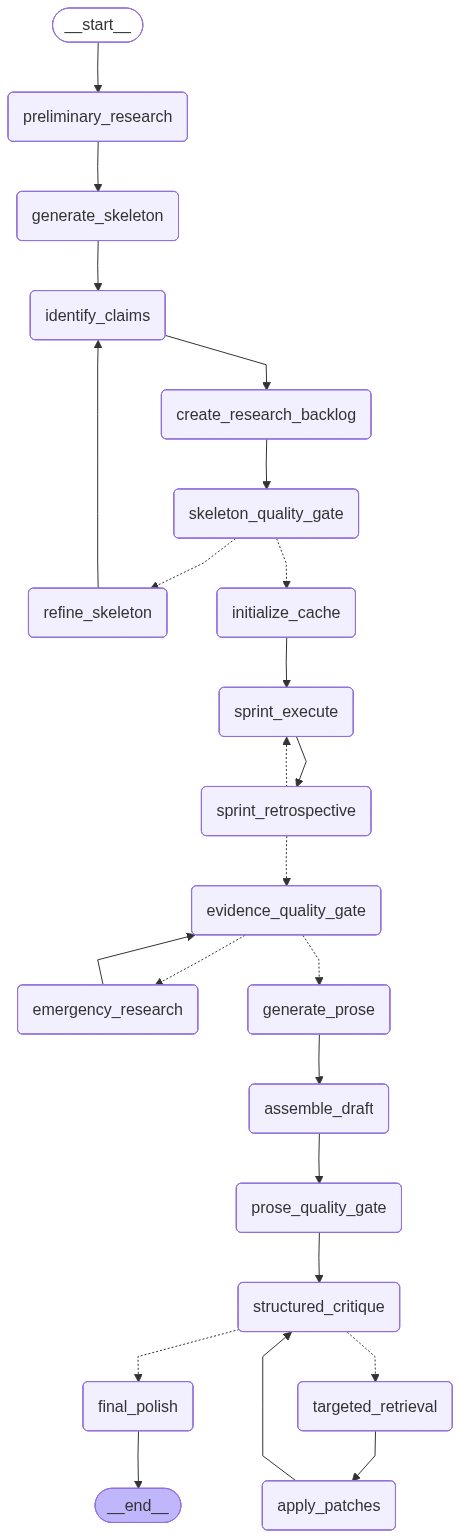

In [30]:
# Visualize the graph
from IPython.display import Image, display, Markdown

try:
    display(Image(sfeo_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 11. Agent Wrappers

Sync and async wrappers for evaluation harness compatibility.

In [31]:
async def sfeo_agent_async(inputs: dict) -> dict:
    """
    Async version of the SFEO research agent.
    Use this version when calling from Jupyter notebooks.
    """
    global knowledge_base
    knowledge_base = None  # Will be initialized during execution
    
    question = inputs.get("question", "")
    
    result = await sfeo_graph.ainvoke(
        {"question": question},
        config={"recursion_limit": 100}
    )
    
    # Gather statistics
    cache_stats = knowledge_base.stats.copy() if knowledge_base else {}
    
    return {
        "output": result.get("final_report", ""),
        "source_urls": list(set(result.get("source_urls", []))),
        "skeleton": result.get("skeleton", {}),
        "claims_registry": result.get("claims_registry", {}),
        "quality_scores": result.get("quality_scores", []),
        "iteration_count": result.get("iteration_count", 0),
        "cache_stats": cache_stats,
        "gate_1_passed": result.get("gate_1_passed", False),
        "gate_2_passed": result.get("gate_2_passed", False),
        "gate_3_passed": result.get("gate_3_passed", False),
        "gate_3_scores": result.get("gate_3_scores", {})
    }


def sfeo_agent(inputs: dict) -> dict:
    """
    Sync wrapper function for SFEO research agent.
    
    Compatible with evaluation harness.
    
    Args:
        inputs: Dictionary with 'question' key
        
    Returns:
        Dictionary with 'output' key containing final report
    """
    question = inputs.get("question", "")
    
    async def _execute():
        global knowledge_base
        knowledge_base = None
        
        return await sfeo_graph.ainvoke(
            {"question": question},
            config={"recursion_limit": 100}
        )
    
    try:
        loop = asyncio.get_running_loop()
        import concurrent.futures
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(asyncio.run, _execute())
            result = future.result()
    except RuntimeError:
        result = asyncio.run(_execute())
    
    cache_stats = knowledge_base.stats.copy() if knowledge_base else {}
    
    return {
        "output": result.get("final_report", ""),
        "source_urls": list(set(result.get("source_urls", []))),
        "skeleton": result.get("skeleton", {}),
        "claims_registry": result.get("claims_registry", {}),
        "quality_scores": result.get("quality_scores", []),
        "iteration_count": result.get("iteration_count", 0),
        "cache_stats": cache_stats
    }


print("Agent wrappers defined")

Agent wrappers defined


## 12. Manual Test

Run this cell to verify the SFEO agent works correctly with a sample research question.

In [32]:
# Manual test with sample question
test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print(f"Testing SFEO Agent")
print(f"Question: {test_question}")
print("\nRunning SFEO research (this may take several minutes)...\n")

try:
    result = await sfeo_agent_async({"question": test_question})
    
    print("\n" + "=" * 80)
    print("FINAL REPORT")
    print("=" * 80)
    print(result["output"][:4000] + "..." if len(result["output"]) > 4000 else result["output"])
    
    print("\n" + "=" * 80)
    print("EXECUTION SUMMARY")
    print("=" * 80)
    print(f"Report length: {len(result['output'])} chars, {len(result['output'].split())} words")
    print(f"Skeleton nodes: {len(result.get('skeleton', {}).get('nodes', {}))}")
    print(f"Claims tracked: {len(result.get('claims_registry', {}))}")
    print(f"Refinement iterations: {result.get('iteration_count', 0)}")
    print(f"Quality progression: {result.get('quality_scores', [])}")
    print(f"Unique sources: {len(result.get('source_urls', []))}")
    
    print(f"\nGate Results:")
    print(f"  Gate 1 (Skeleton): {'PASSED' if result.get('gate_1_passed') else 'FAILED'}")
    print(f"  Gate 2 (Evidence): {'PASSED' if result.get('gate_2_passed') else 'FAILED'}")
    print(f"  Gate 3 (Prose): {'PASSED' if result.get('gate_3_passed') else 'FAILED'}")
    
    cache_stats = result.get("cache_stats", {})
    if cache_stats:
        total = cache_stats.get("total_queries", 0)
        avoided = cache_stats.get("web_searches_avoided", 0)
        hit_rate = avoided / total * 100 if total else 0
        print(f"\nCache Performance:")
        print(f"  Total queries: {total}")
        print(f"  Web searches avoided: {avoided} ({hit_rate:.1f}%)")
        print(f"  L1 hits: {cache_stats.get('l1_hits', 0)}")
        print(f"  L2 high: {cache_stats.get('l2_high', 0)}")
        print(f"  L2 medium: {cache_stats.get('l2_medium', 0)}")
        print(f"  L2 low: {cache_stats.get('l2_low', 0)}")
    
    print("\nAgent test PASSED")
    
except Exception as e:
    print(f"Agent test FAILED: {e}")
    import traceback
    traceback.print_exc()
    raise

Testing SFEO Agent
Question: What are the key benefits and challenges of using large language models in enterprise applications?

Running SFEO research (this may take several minutes)...


Phase A.1: Preliminary Research
  Searching: "Key benefits of large language models in enterpri...
  Searching: "Challenges of deploying LLMs in enterprises: priv...
  Searching: "Best practices for integrating and operating LLMs...
  Searching: "Enterprise LLM case studies and use cases by indu...
  Collected 20 preliminary results

Phase A.2: Skeleton Generation
  Thesis: Enterprise LLMs deliver substantial ROI and transformative automation only when ...
  Generated 7 skeleton nodes:
    - sec:introduction: Introduction: LLMs in the Enterprise Landscape
    - sec:background: Background and Context: LLM Technology, Models, and Enterprise Trends (depends: sec:introduction)
    - sec:benefits: Benefits: Business Value and Use Cases for Enterprise LLMs (depends: sec:background)
    - sec:challenges: Ch

In [33]:
display(Markdown(result["output"]))

# Research Report

**Thesis:** Enterprise LLMs deliver substantial ROI and transformative automation only when they are integrated into existing workflows with production-grade MLOps, governance, and data-quality practices; absent these, cost, security, and operational risk prevent scalable value capture.

---

## Benefits: Business Value and Use Cases for Enterprise LLMs

Having established the capabilities and architectural patterns of enterprise LLMs, we now consider the concrete business value they unlock across core functions. Enterprise LLMs deliver measurable value in productivity, customer experience, automation, knowledge management, and decision support. In software engineering, studies report up to a 30% reduction in task completion time for routine coding activities when developers use LLM assistance, illustrating a direct productivity delta that can scale across teams and projects [1]. Those productivity gains extend beyond code: LLMs accelerate research, ideation, and document synthesis across R&D, legal, and other knowledge‑intensive functions, enabling faster iteration cycles and higher throughput per employee [2].

Knowledge management and time‑to‑insight are among the highest‑value use cases. Retrieval‑Augmented Generation (RAG) transforms enterprise search from static lookup into an active, contextualized assistant, shortening the interval between asking a question and acting on the answer and thus reducing decision latency in operations and customer service [3]. By combining retrieval and generation into a single response, RAG improves contextual accuracy and relevance of outputs, making downstream workflows—ticket resolution, onboarding, and compliance checks—both faster and more reliable [4].

Customer experience and automation benefit when LLMs are embedded into workflows rather than treated as point tools. Modern enterprise models can call external tools, persist memory, and orchestrate multi‑step tasks, enabling agentic workflows that autonomously complete routine processes and surface exceptions for human review [5][6]. This integration amplifies value by reducing handoffs, increasing adoption (because outputs arrive where work already happens), and creating feedback loops that improve accuracy and governance. In aggregate, these effects compound: time savings per task become organizational velocity, customer satisfaction rises through faster, more personalized responses, and decision support becomes both timely and actionable. The benefits above are compelling, but realizing them at scale requires confronting several technical, operational, and governance challenges. The next section details those key risks and their business implications.

## Challenges and Risks: Accuracy, Costs, Security, and Operational Complexity

The productivity and automation gains described earlier bring enterprises to a tipping point: operationalizing LLMs at scale exposes a distinct set of technical, financial, and compliance risks that can negate those benefits if not managed. First, model accuracy and hallucination remain the most visible operational risk. Industry analysis identifies hallucination as one of three dominant risks for enterprises entering 2026—alongside hidden costs and data leakage—which places factuality squarely on CIO and CISO agendas [1]. In regulated or safety-critical workflows, even low-frequency hallucinations are unacceptable: outputs that are “close enough” in creative tasks can become material errors in financial disclosures, clinical support, or compliance reporting [2]. Mitigation therefore requires layered defenses (retrieval augmentation, grounding, constrained generation, human-in-the-loop review) and rigorous evaluation against domain-specific ground truth.

Second, inference and storage costs create recurring financial pressure. Multiple benchmarks and strategy reviews find that inference compute is a major, recurring operational cost for deployed LLM services, and the industry has become singularly focused on inference scaling and cost reduction techniques [3][4]. Without optimization—model quantization, batching, dynamic routing, or hybrid deployment of smaller private models plus managed APIs—per-query cost can escalate as usage grows, turning a pilot into an unsustainable line-item on the P&L.

Third, latency, scalability, and data integration are practical barriers to reliable production performance. High throughput requirements interact with model size and retrieval latency, producing user-visible delays unless caching, sharding, and retrieval-augmented pipelines are implemented. At the same time, decision quality depends on data quality operations: stale, misaligned, or poorly versioned context feeds produce systematic errors that propagate through downstream workflows [6]. Prompt defects and poor prompt governance further create “LLM waste,” a cross-industry source of risk seen in finance, manufacturing, energy, and healthcare [5].

Finally, security, privacy, and governance risks—particularly data leakage and inadequate model auditing—translate directly into business exposure. Data exfiltration or noncompliant usage can trigger regulatory fines, contractual penalties, and loss of customer trust; weak model versioning and observability amplify these outcomes by delaying detection and remediation [1][5]. Together, these challenges mean that technical shortcomings rapidly convert into financial, legal, and reputational impacts unless operational controls and governance are prioritized. The next section outlines pragmatic production patterns and operational controls—hybrid architectures, retrieval layers, caching strategies, observability, and CI/CD practices—that address the specific risks identified here.

## Deployment, Architecture, and LLMOps: From Pilot to Production

Having established where LLM risk concentrates—factuality, costs, latency, data quality, and security—deployment decisions must translate those risks into concrete operational controls. Enterprise LLM deployments should follow pragmatic, incremental patterns that balance control, cost, and capability. A hybrid architecture is often the practical default: host sensitive, regulated, or frequently accessed models and data in private infrastructure (on-premise or private cloud) while routing less-sensitive or experimental workloads to managed APIs. This split enables tight data governance and low-latency local inference for critical paths while preserving agility and access to the newest model capabilities via managed providers. The architecture should include a clear model router that applies policy-based routing (by sensitivity, latency target, cost budget, or model capability) and records routing decisions for audit and billing.

A robust retrieval layer is essential to contain hallucination risk and inference costs. Indexes, vector stores, and knowledge graphs must be treated as first-class services with versioned schemas, access controls, and periodic refresh windows. Caching and result memoization—both at the retrieval and output levels—reduce repeated token-generation costs; deterministic responses (e.g., templated answers or frequently seen queries) should be cached and served without model invocation. Latency optimization requires multiple knobs: model selection by SLA tier, batching small requests, asynchronous and streaming responses for long outputs, colocating retrieval and inference services, and using lower-precision or distilled models for conversational “frontline” tasks.

Operational controls include strict versioning and a model registry that ties model artifacts to training data hashes, evaluation suites, and deployment metadata. CI/CD for models extends code pipelines with data and evaluation gates: automated unit tests on prompts, regression suites for factuality and safety, canary rollouts with staged traffic, and automated rollback triggers when key metrics degrade. Observability must instrument latency, throughput, cost per request, prompt/response drift, hallucination/factuality rates, and safety incidents; logs should be retained with lineage for post-incident forensics.

Prompt lifecycle management—treating prompts as deployable artifacts with tests, reviews, and metrics—prevents operational drift. Finally, cost-control strategies are operational: tiered model SLAs, dynamic routing to cheaper models for non-critical queries, per-feature quotas, token limits, precomputation, and active cache policies. Taken together, these patterns form a repeatable roadmap to move from pilot experiments to resilient, auditable, and cost-efficient production LLM services. With deployment patterns and operational controls in place, the report next synthesizes core findings and recommends immediate and strategic actions for enterprise investment and governance.

## Conclusion and Future Directions

Building on the pragmatic hybrid architecture and LLMOps practices just described, this conclusion synthesizes the report’s core lessons and translates them into concrete next steps for enterprises. The evidence in this report supports a single, central thesis: reliable, scalable LLM-driven systems require both an architecture that combines retrieval, caching, and cost/latency optimization and an operational discipline that treats prompts and models like software artifacts. Practically, enterprises should prioritize immediate, low-friction actions that reduce risk and demonstrate value. Short-term actions include: (1) cataloging current data sources and model usage, (2) defining clear business success metrics and latency/SLA budgets, (3) implementing a retrieval layer and response caching to cut cost and improve relevance, and (4) establishing baseline observability, logging, and prompt/versioning policies so incidents are traceable and reproducible.

Over the longer term, organizations must invest in platform capabilities and governance to sustain growth. Key longer-term investments are: a central model-ops platform that automates deployment, rollbacks, and cost-aware routing; multimodal data pipelines to support vision and audio modalities; formalized governance, audit trails, and policy-as-code to meet compliance needs; staff training and role definition for model stewards; and R&D into agent orchestration and safety frameworks before deploying autonomous agents at scale. 

Several emerging trends deserve directed attention as research or pilot priorities. Agentic AI (autonomous, multi-step agents) promises productivity gains but raises safety, explainability, and control questions that should be addressed via contained pilots and red-team testing. Multimodal models expand use cases but require data engineering and labeling investment. Model marketplaces and vendor ecosystems ease access but increase dependency and procurement risk, so pilots should evaluate portability and cost models. Finally, evolving regulation will change compliance baselines; organizations should pilot auditability, provenance tracking, and privacy-preserving techniques now. These steps form a pragmatic roadmap from pilot to production while keeping safety, cost, and governance central. The final section closes the report with a concise recap and calls to action that synthesize these recommendations into an executable agenda for leadership.

---

## References

[1] Using LLMs to Boost Workplace Productivity - LinkedIn. https://www.linkedin.com/top-content/productivity/maximizing-workplace-productivity/using-llms-to-boost-workplace-productivity/

[2] Using LLMs to augment human-centered workflows - Effixis. https://effixis.ch/blog/using-llms-to-augment-human-centered-workflows/

[3] How is RAG Reinventing Enterprise Search and Reducing Time-to .... https://www.kore.ai/blog/how-is-rag-reinventing-enterprise-search-and-reducing-time-to-insight

[4] Questions? Retrieval Augmented Generation (RAG) Has the Answer. https://www.reworked.co/knowledge-findability/employees-need-information-retrieval-augmented-generation-rag-can-help/

[5] Agentic Workflows in 2026: What They Are & How They Work. https://brollyai.com/agentic-workflows/

[6] Agentic AI Is Redefining Enterprise Workflows in 2026 - CrossML. https://www.crossml.com/agentic-ai-is-redefining-enterprise-workflows/

[7] The 3 Biggest Risks of LLMs Going Into 2026. https://medium.com/@serdargoksu/the-3-biggest-risks-of-llms-going-into-2026-hallucination-hidden-costs-and-data-leakage-f952fcb94506

[8] Are LLM Hallucinations a Business Risk? Enterprise and .... https://www.factors.ai/blog/llm-hallucination-business-risk

[9] Cost-Effective AI Inference at Scale: A 2025 Benchmark & Strategy .... https://www.gmicloud.ai/blog/cost-effective-ai-inference-at-scale

[10] How To Reduce Inference Costs While Running LLMs. https://levelup.gitconnected.com/how-to-reduce-inference-costs-while-running-llms-748b373f2d3d

[11] The Hidden Bottleneck in AI: LLM Waste | Craig Saunders posted on .... https://www.linkedin.com/posts/craigjsaunders_people-talk-about-the-bottleneck-in-ai-being-activity-7384192522710880256-VsH0

[12] Why Decision Quality Is the Real AI Bottleneck in GTM - LinkedIn. https://www.linkedin.com/pulse/infrastructure-gap-why-decision-quality-real-ai-bottleneck-alan-zhao-x8uie



## 13. Evaluation Harness Integration

Use the evaluation harness to formally benchmark the SFEO agent.

In [ ]:
# Uncomment to run evaluation harness
# import sys
# sys.path.insert(0, '../evaluation')
# from harness import evaluate_agent

# Run evaluation (uncomment when ready)
# eval_result = evaluate_agent(
#     agent_fn=sfeo_agent,
#     agent_name="sfeo_combined_tier1",
#     questions=[
#         {"question": "What is the current state of quantum computing technology and its near-term applications?"},
#         {"question": "How do self-driving cars detect and respond to pedestrians?"},
#     ],
#     output_path="../results/sfeo_combined_tier1_results.json"
# )
# print(eval_result)

print("Evaluation harness integration ready")
print("Uncomment the code above to run formal benchmarks")

---

## Summary

This notebook implements the **Skeleton-First Evidence Orchestration (SFEO)** architecture, combining all validated Tier 1 paradigms:

### Architecture Overview

| Phase | Components | Key Innovation |
|-------|------------|----------------|
| **A: Strategic Planning** | Preliminary Research → Skeleton → Claims → Backlog → Gate 1 | Document structure drives research |
| **B: Evidence Gathering** | Cache Init → Sprint Loop → Gate 2 | Cascading 3-layer cache + agile sprints |
| **C: Document Construction** | Prose Generation → Assembly → Gate 3 | Claim-evidence driven prose |
| **D: Refinement** | Critique → Targeted Retrieval → Patch → Converge | Semantic addressing + cascade detection |

### Key Features

1. **Skeleton-First**: The document skeleton is generated BEFORE evidence gathering, focusing research on specific claims
2. **Quality Gates**: Three gates prevent error propagation between phases
3. **Cascading Cache**: 3-layer cache (L1: exact, L2: semantic, L3: LLM judgment) optimizes searches
4. **Sprint-Based Research**: Agile-style sprints with retrospectives enable adaptive evidence gathering
5. **Patch-Based Refinement**: Targeted updates with cascade detection maintain document coherence

### Expected Performance

- **Search Efficiency**: 30-50% cache hit rate in later phases
- **Quality Scores**: Target 7.5+/10 overall quality
- **Token Efficiency**: More focused research than baseline approaches
- **Document Coherence**: Bridge sentences and cascade detection ensure flow

### Next Steps

1. Run manual test to verify agent execution
2. Use evaluation harness for formal benchmarking
3. Compare results against Baseline A/B

# Test Execution Section

This section runs the 5-query test dataset against this notebook variant and saves outputs for comparison.

**Output Structure:**
```
test_output/
    question_1/
        question_1_V08-2.md
    question_2/
        question_2_V08-2.md
    ...
```

**Instructions:**
1. Run all cells above first to define the agent
2. Run the cells below to execute all 5 test questions

In [ ]:
# Test Setup and Configuration
import os
import yaml
import json
from datetime import datetime
from pathlib import Path

# Configure paths
NOTEBOOK_DIR = Path('.').resolve()
OUTPUT_DIR = NOTEBOOK_DIR / 'test_output'
DATASET_PATH = NOTEBOOK_DIR / 'test_dataset.yaml'

# Notebook version (automatically set based on filename)
CURRENT_VERSION = "V08-2"

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

# Load test dataset
with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    dataset = yaml.safe_load(f)

questions = dataset.get('questions', [])

# Create output directories for each question
for i in range(1, len(questions) + 1):
    question_dir = OUTPUT_DIR / f"question_{i}"
    question_dir.mkdir(exist_ok=True)

print(f"Test Configuration:")
print(f"  Version: {CURRENT_VERSION}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Loaded {len(questions)} test questions")
print(f"\nTest Questions:")
for i, q in enumerate(questions, 1):
    print(f"  {i}. [{q['category']}] {q['title']}")

In [ ]:
def save_output(question_num: int, version: str, result: dict, question_data: dict) -> Path:
    """Save the output to a markdown file."""
    output_dir = OUTPUT_DIR / f"question_{question_num}"
    output_file = output_dir / f"question_{question_num}_{version}.md"
    
    question_text = question_data.get('question', '')
    question_title = question_data.get('title', 'Untitled')
    question_id = question_data.get('id', f'Q{question_num}')
    
    content = f"""# Question {question_num} - {version}

                **Question ID:** {question_id}  
                **Title:** {question_title}  
                **Category:** {question_data.get('category', 'N/A')}  

                ---

                ## Original Question

                {question_text}

                ---

                ## Research Report

                {result.get('output', 'No output generated')}

                """
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(content)
    
    return output_file

print("Helper functions defined.")

## Run All Questions Test

Run ALL 5 questions for comprehensive testing:

**WARNING:** This will take 30-60+ minutes to complete.

In [ ]:
# Run ALL questions for the current version
# WARNING: This will take a long time (potentially 30-60+ minutes)

print(f"Running ALL {len(questions)} questions with {CURRENT_VERSION}")
print(f"Estimated time: 30-60+ minutes")
print("="*60 + "\n")

results_summary = []
overall_start = datetime.now()

for i, question_data in enumerate(questions, 1):
    question_text = question_data.get('question', '')
    
    print(f"\n{'='*60}")
    print(f"Question {i}/{len(questions)}: {question_data['title']}")
    print(f"{'='*60}\n")
    
    start_time = datetime.now()
    
    try:
        result = await combined_tier1_agent_async({"question": question_text})
        elapsed = (datetime.now() - start_time).total_seconds()
        
        output_file = save_output(i, CURRENT_VERSION, result, question_data)
        
        summary = {
            "question": i,
            "title": question_data['title'],
            "version": CURRENT_VERSION,
            "elapsed_seconds": elapsed,
            "output_chars": len(result.get('output', '')),
            "sources": len(result.get('source_urls', [])),
            "status": "success"
        }
        
        print(f"Completed in {elapsed:.1f}s - {summary['output_chars']} chars, {summary['sources']} sources")
        
    except Exception as e:
        elapsed = (datetime.now() - start_time).total_seconds()
        summary = {
            "question": i,
            "title": question_data['title'],
            "version": CURRENT_VERSION,
            "elapsed_seconds": elapsed,
            "output_chars": 0,
            "sources": 0,
            "status": f"error: {str(e)}"
        }
        print(f"FAILED: {e}")
    
    results_summary.append(summary)

# Save summary
overall_elapsed = (datetime.now() - overall_start).total_seconds()

summary_file = OUTPUT_DIR / f"summary_{CURRENT_VERSION}.json"
with open(summary_file, 'w', encoding='utf-8') as f:
    json.dump({
        "run_time": datetime.now().isoformat(),
        "version": CURRENT_VERSION,
        "total_elapsed_seconds": overall_elapsed,
        "questions_tested": len(questions),
        "results": results_summary
    }, f, indent=2)

print(f"\n{'='*60}")
print(f"ALL TESTS COMPLETE for {CURRENT_VERSION}")
print(f"{'='*60}")
print(f"Total time: {overall_elapsed:.1f} seconds ({overall_elapsed/60:.1f} minutes)")
print(f"Summary saved: {summary_file}")